# qube-calib の使い方

`QubeCalib` は `e7awgsw` や `qubelsi` をできるだけ薄くラップする方針で作ってきた．しかし，変な実装の積み重ねで特に `e7awgsw` などが見えなくなって身動きが取れなくなってきている．Qubit チップのアップデート作業に差し掛かっているこの機会に，利便性と将来の機能拡張への対応を狙っていろんな実装を整理している．その過程で，同じ処理を「e7awgsw を生で書くとこう」「qube-calib で被せる部分はこんな感じで書いている」「qube-calib を積極的に使うとこう」みたいなのを併記したメモを作成した．

## Qube のハードウェア構成

これから書く

## Qube オブジェクトの生成

qube-calib では Qube 装置へのアクセスを qubecalib.qube.Qube オブジェクトを介して行います．装置の再起動やリセットを簡単に操作するための gui を提供する qubecalib.ui.QubeControl オブジェクトを用いても Qube オブジェクトを取得できます．qubecalib.ui.QubeControl の各機能は qubecalib.boottools に関数として（これから）まとめるので，それらの関数を実行することでバッチ実行することもでき（るようになり）ます．

### 電源投入時の操作
- `[Boot Unit]` ボタンを押し Qube ユニットの AU50 を再起動し LSI 類を初期化する．

<!--
- `[do_init]` ボタンは Qube ユニットの LSI 類を再起動します．AU50 は再起動しません．通常は実行しないでください．
- `[Kick soft reset]` ボタンはうまく動きません．実行しないでください．（そのうち隠します．）
-->

### `LinkStatus` の `0x55E` が `0xE0` 以外の値を示しているとき，
次の優先順位で操作してください．
1. `[Reatart AD9082]` ボタンを押しデータコンバータのみを再起動する．
1. `[do_init]` ボタンを押し各種 LSI 類を初期化する．
1. `[Boot Unit]` ボタンを押し Qube ユニットの AU50 を再起動し LSI 類を初期化する．

### `awg timeout` や `capture unit timeout` などのエラーが直らない場合の復帰操作
AU50 の再起動が必要です．
1. `[Boot Unit]` ボタンを押し Qube ユニットの AU50 を再起動し LSI 類を初期化する．


### qubecalib.ui.QubeControl による Qube オブジェクトの生成例

In [2]:
import qubecalib as qc
# ---- このタイミングでインポートすること ----
%matplotlib inline
import matplotlib.pyplot as plt
# --------------------------------------
qc.ui.MATPLOTLIB_PYPLOT = plt
qube = qube1 = qc.ui.QubeControl('qube_riken_1-02.yml').qube

In [4]:
import qubecalib as qc
# ---- このタイミングでインポートすること ----
%matplotlib inline
import matplotlib.pyplot as plt
# --------------------------------------
qc.ui.MATPLOTLIB_PYPLOT = plt
qube2 = qc.ui.QubeControl('qube_riken_1-09.yml').qube

## 1. LSI の設定方法
    周波数
    出力
    経路スイッチ

In [3]:
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

65535

## 2. 波形の出力方法

### 2.1 WaveSequence の設定

In [11]:
import e7awgsw
w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(32767,0),],num_blank_words=0,num_repeats=1)

In [37]:
a = qube.port0.awg0.id
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    

In [9]:
w = qc.meas.WaveSequenceFactory()
w.new_chunk(duration=128e-9)
w.chunk[-1].iq[10:20]=1

## 3. 波形の観測方法

### 3.1 CaptureParam の設定
DSP を使わない．生データの観測．

In [25]:
p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=32, num_post_blank_words=1)
p.capture_delay = 0

### 3.2 CaptureModule を自走スタートさせる方法

In [26]:
p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=32, num_post_blank_words=1)
p.capture_delay = 0

u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.CaptureCtrl(qube.ipfpga) as r:
    r.initialize(u)
    r.set_capture_params(u, p)
    r.start_capture_units(u)
    r.wait_for_capture_units_to_stop(10, u)
    r.check_err(u)

### Capture したデータを取得する方法

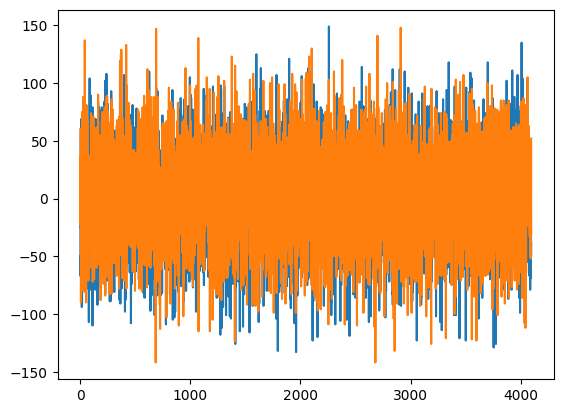

In [11]:
import numpy as np
import e7awgsw

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=32, num_post_blank_words=1)
p.capture_delay = 0

u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.CaptureCtrl(qube.ipfpga) as r:
    n = r.num_captured_samples(u)
    c = np.array(r.get_capture_data(u,n))
    r.check_err(u)
    d = c[:,0] + 1j * c[:,1]
plt.plot(np.real(d))
plt.plot(np.imag(d))


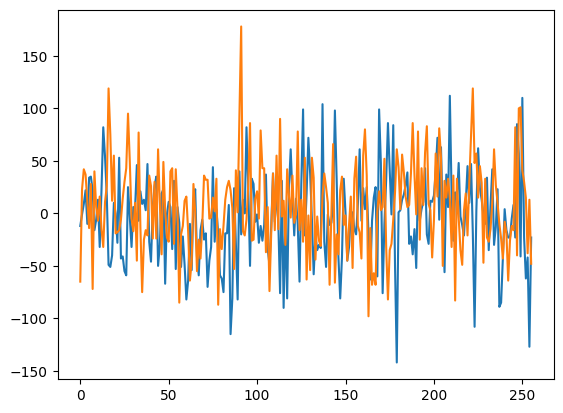

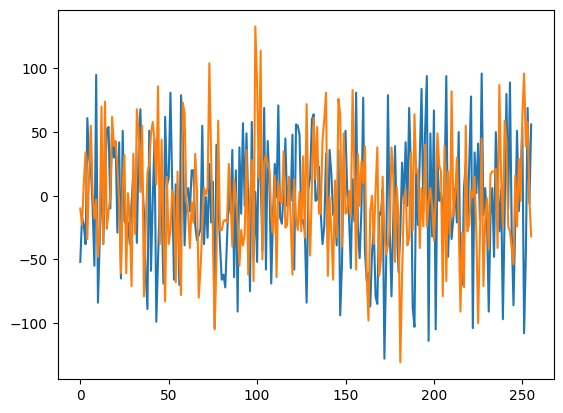

In [61]:
import qubecalib as qc
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from qubecalib.backendqube import Send, Recv
from contextlib import redirect_stdout
from concurrent.futures import ThreadPoolExecutor
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor
import tqdm

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.gpio.write_value(0x0000) # Output

prx = qube1.port1
prx.lo.mhz = 8000
prx.nco.mhz = 2000

def standalone_recv(*setup,timeout=30):
    with Recv(*setup) as c:
        c.start(timeout)
        d = c.get()
    return d

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # n * 16 でアライメントされる

setup = ((qube1.port1.capt.unit0, p),(qube1.port12.capt.unit0, p))

ret = standalone_recv(*setup)

for u, d in ret.items():
    plt.plot(np.real(d))
    plt.plot(np.imag(d))
    plt.show()


## 4. 波形の出力と観測を同期させる方法

### 4.1. 波形を出力する

### 4.2. 波形を入出力する

CaptureModule をトリガスタートさせる

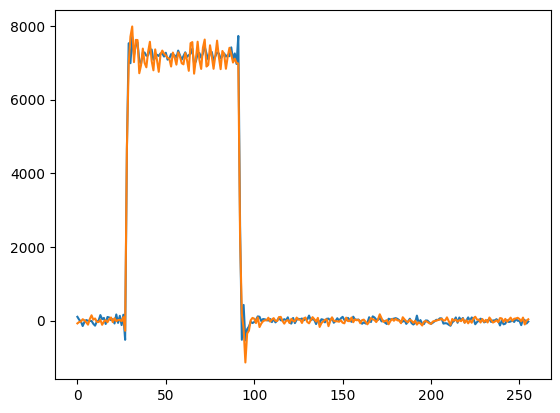

In [34]:
import numpy as np
import e7awgsw

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=0,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

a = qube.port0.awg0.id
u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    cc.initialize(u)
    cc.set_capture_params(u, p)
    cc.select_trigger_awg(qube.port1.capt.id,qube.port0.awg0.id)
    cc.enable_start_trigger(u)
    
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    
    cc.wait_for_capture_units_to_stop(10, u)
    cc.check_err(u)
    n = cc.num_captured_samples(u)
    c = np.array(cc.get_capture_data(u,n))
    cc.check_err(u)
    d = c[:,0] + 1j * c[:,1]
plt.plot(np.real(d))
plt.plot(np.imag(d))


### qube-calib ではこう書く

#### `qubecalib.backendqube.Send` と `qubecalib.backendqube.Recv` を使う場合

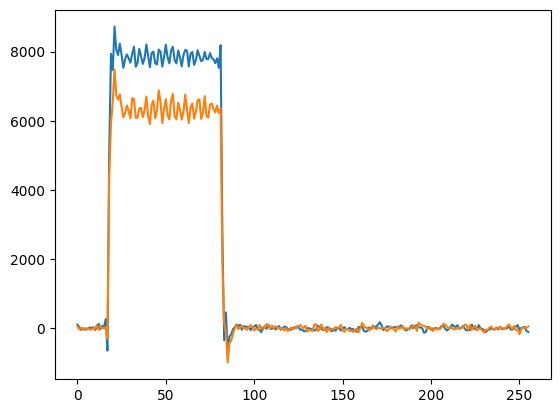

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=0,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

awg_wseq = ((qube.port0.awg0, w),)
cpt_cprm = ((qube.port1.capt.unit0, p),)

with be.Send(*awg_wseq) as ac, be.Recv(*cpt_cprm) as cc:
    cc.prepare_for_trigger(qube.port0.awg0)
    ac.send()
    cc.wait_for_capture(timeout=10)
    d = cc.get()

plt.plot(np.real(d[qube.port1.capt.unit0]))
plt.plot(np.imag(d[qube.port1.capt.unit0]))


#### `qubecalib.backendqube.standalone_send_recv` を使う場合
(awg, wavesequence) や (captureunit, captureparam) などを列挙したタプルを引数として与えます．

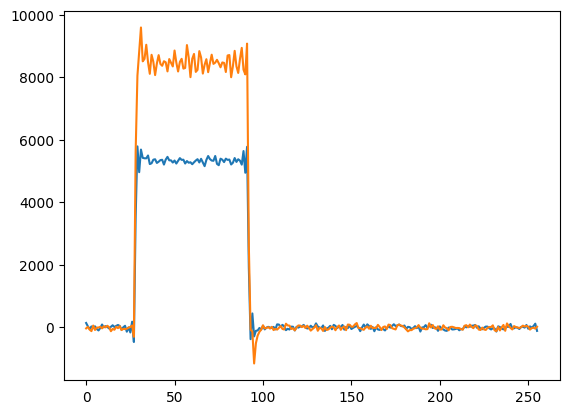

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=0,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)

d = be.standalone_send_recv(*setup,trig=qube.port0.awg0,timeout=10)

plt.plot(np.real(d[qube.port1.capt.unit0]))
plt.plot(np.imag(d[qube.port1.capt.unit0]))
plt.show()

## 5. 複数の筐体を同期する方法

### 生の e7awgsw で書いてみる

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


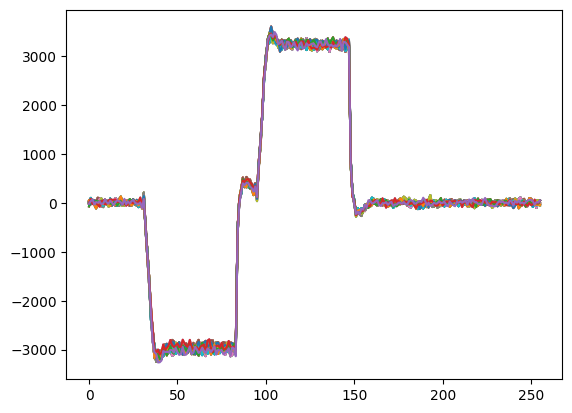

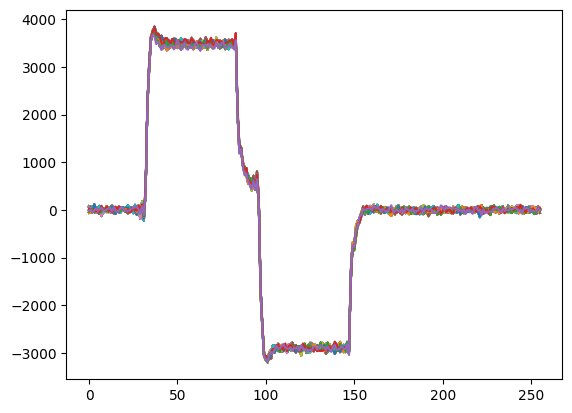

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import e7awgsw
import qubecalib as qc
import numpy as np
from contextlib import redirect_stdout
from concurrent.futures import ThreadPoolExecutor
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor
import tqdm

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00

def get_data(capt_ctrl, unit, cprm):
    n = capt_ctrl.num_captured_samples(unit)
    c = np.array(capt_ctrl.get_capture_data(unit, n))
    capt_ctrl.check_err(unit)
    return c[:,0] + 1j * c[:,1]

def send(send):
    qube = send[0][0].port.qube
    a = [a.id if isinstance(a,qc.qube.AWG) else a for a, w in send]
    with e7awgsw.AwgCtrl(qube.ipfpga) as ac:
        ac.initialize(*a)
        for k, v in send:
            ac.set_wave_sequence(k.id if isinstance(k,qc.qube.AWG) else k, v)
        ac.wait_for_awgs_to_stop(10, *a)
    return None

def send_recv(send,recv,trig):
    qube = send[0][0].port.qube
    capts = list(set([u.capt.id for u, p in recv]))
    awgs = [a.id if isinstance(a,qc.qube.AWG) else a for a, w in send]
    units = [u.id if isinstance(u,qc.qube.UNIT) else u for u, p in recv]
    send = [(a.id, w) if isinstance(a,qc.qube.AWG) else (a, w) for a, w in send]
    old_recv = recv
    recv = [(u.id, p) if isinstance(u,qc.qube.UNIT) else (u, p) for u, p in recv]
    trig = trig.id if isinstance(trig,qc.qube.AWG) else trig
    with\
        e7awgsw.AwgCtrl(qube.ipfpga) as ac,\
        e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
            
            cc.initialize(*units)
            for u, p in recv:
                cc.set_capture_params(u, p)
            for c in capts:
                cc.select_trigger_awg(c, trig)
            cc.enable_start_trigger(*units)
            
            ac.initialize(*awgs)
            for a, w in send:
                ac.set_wave_sequence(a, w)
            ac.wait_for_awgs_to_stop(10, *awgs)
            
            cc.wait_for_capture_units_to_stop(10, *units)
            cc.check_err(*units)

            d = {u: get_data(cc,u.id,p) for u, p in old_recv}
    return d
    
def kick(destinations):
    DAQ_INITSDLY = 1                                # seconds; synchronization delay
    cDAQ_SDLY_TAG = DAQ_INITSDLY
    SYNC_CLOCK = 125_000_000 # 125Mcycles = 1sec
    
    delay = int(cDAQ_SDLY_TAG * SYNC_CLOCK + 0.5)

    seq_cli = {a:SequencerClient(a, 16384) for a in destinations}
    mon = QuBEMonitor(destinations[0], 16385)
    clock = mon.read_time() + delay
    
    for a in destinations:
        seq_cli[a].add_sequencer(16*(clock//16+1))

TARGET_QUBE = [q.ipfpga for q in [qube1, qube2]]
DESTINATIONS = [q.ipmulti for q in [qube1,qube2]]
num_repeats = 10

kwargs = {
    'iq_samples': 64*[(int(0.05*32767),0),],
    'num_blank_words': 0,
    'num_repeats': 1,
}
w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)
w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 7*16 # n * 16 でアライメントされる

send1 = ((qube1.port0.awg0, w1),)
recv1 = ((qube1.port1.capt.unit0, p),)
send2 = ((qube2.port0.awg0, w2),)

threads, rets = [], []
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        with ThreadPoolExecutor() as e:
            t = e.submit(lambda: send_recv(send1,recv1,qube1.port0.awg0))
            threads.append(t)
            t = e.submit(lambda: send(send2))
            threads.append(t)
            
            kick(DESTINATIONS)

            rets.append([o for o in [thread.result() for thread in threads] if o is not None])

for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.real(r[u]))
plt.show()
for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.imag(r[u]))
plt.show()


### qube-calib ではこう書く１（`backendqube.Send`,`backendqube.Recv` を使う書き方）

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


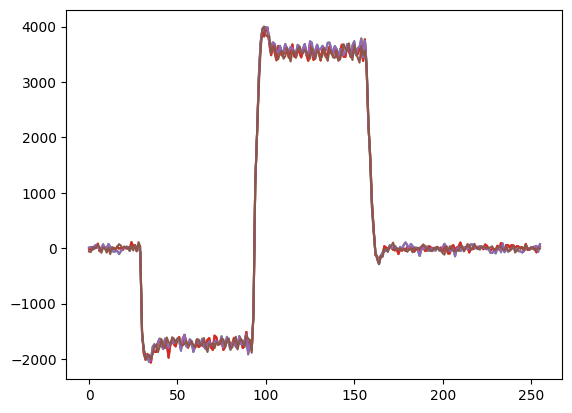

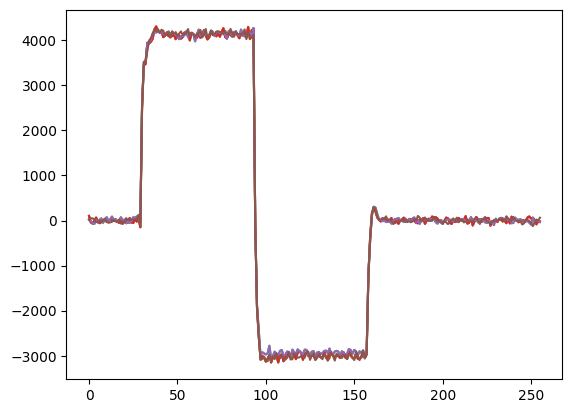

In [9]:
import qubecalib as qc
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from qubecalib.backendqube import Send, Recv
from contextlib import redirect_stdout
from concurrent.futures import ThreadPoolExecutor
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor
import tqdm

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00

def send(send):
    with Send(*send) as c:
        c.prepare_for_sequencer(10)
    return None

def send_recv(send,recv,trig=None):
    with Send(*send) as ac, Recv(*recv) as cc:
        cc.prepare_for_trigger(trig)
        ac.prepare_for_sequencer(10)
        cc.wait_for_capture(10)
        d = cc.get()
    return d
    
num_repeats = 3

kwargs = {
    'iq_samples': 64*[(int(0.05*32767),0),],
    'num_blank_words': 0,
    'num_repeats': 1,
}
w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)
w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # n * 16 でアライメントされる

send1 = ((qube1.port0.awg0, w1),)
recv1 = ((qube1.port1.capt.unit0, p),)
send2 = ((qube2.port0.awg0, w2),)

threads, rets = [], []
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        with ThreadPoolExecutor() as e:
            t = e.submit(lambda: send_recv(send1,recv1,trig=qube1.port0.awg0))
            threads.append(t)
            t = e.submit(lambda: send(send2))
            threads.append(t)
            
            be.kick(qube1, qube2)
            
            rets.append([o for o in [thread.result() for thread in threads] if o is not None])

for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.real(r[u]))
plt.show()
for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.imag(r[u]))
plt.show()


### qube-calib ではこう書く２（`backendqube.send_recv` にお任せのやり方）

`backendqube.send_recv` は与えられたセットアップを自動的に判別して適切な設定で qube 達を動かす．
各 QuBE のクロックが十分近接していれば？ 0.2 秒ぐらいの遅延でも大丈夫．

前項までから拡張して，複数の積算区間，複数の総和区間を設定した場合も正しく動く．

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.69it/s]

integ_section: 0


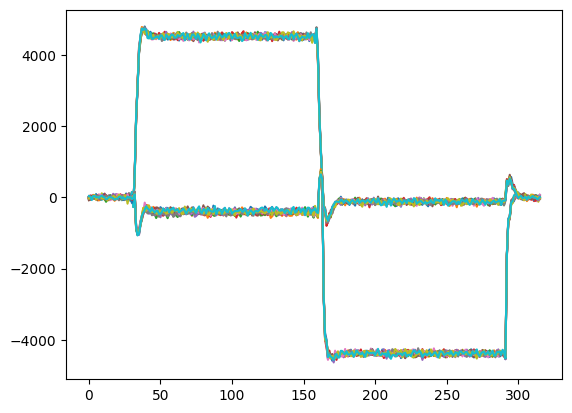

integ_section: 1


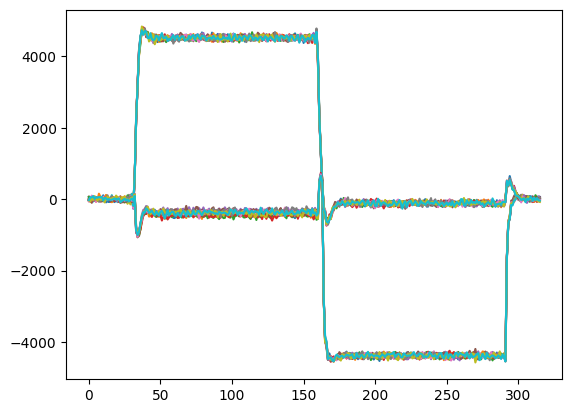

integ_section: 2


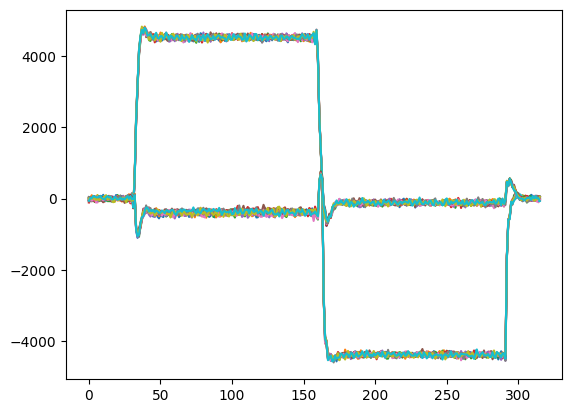

integ_section: 3


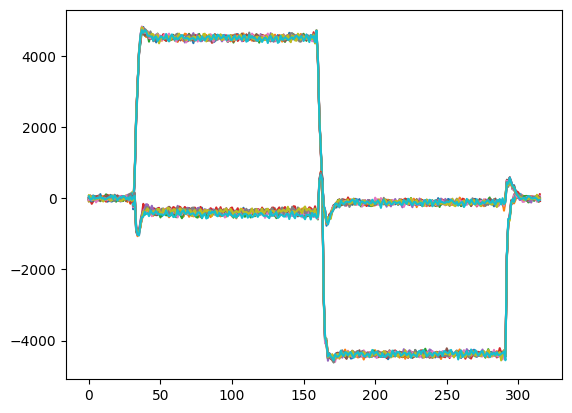

integ_section: 0


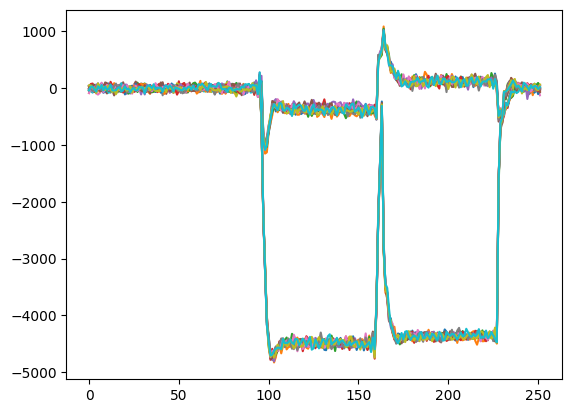

integ_section: 1


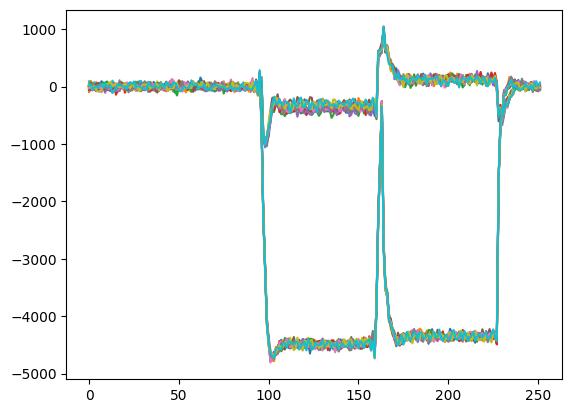

integ_section: 2


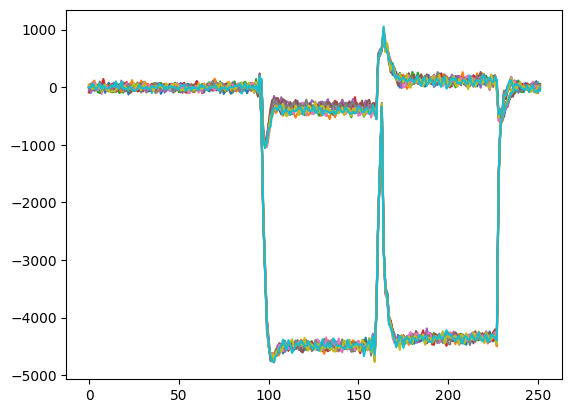

integ_section: 3


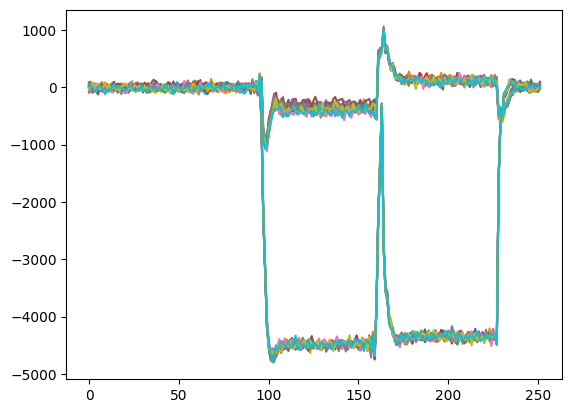

integ_section: 0


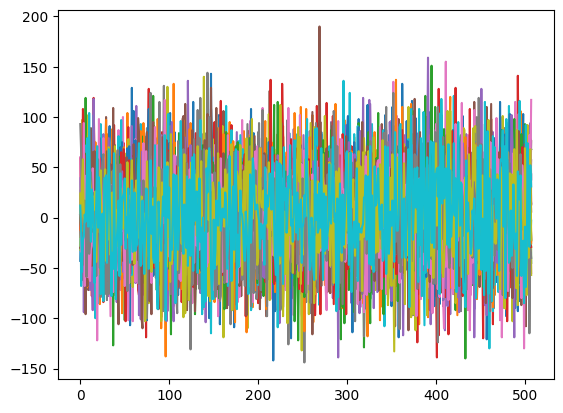

In [1]:
import qubecalib as qc
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00

num_repeats = 10

w1 = e7awgsw.WaveSequence(num_wait_words=36,num_repeats=4) # 1 word = 4 samples = 8 ns
w1.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=48,num_repeats=1)
w1.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=48,num_repeats=1)

w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=4) # 1 word = 4 samples = 8 ns
w2.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=64,num_repeats=1)
w2.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=32,num_repeats=1)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 4
p1.add_sum_section(num_words=79, num_post_blank_words=1)
p1.add_sum_section(num_words=63, num_post_blank_words=1)
p1.capture_delay = 7*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=127, num_post_blank_words=1)
# p2.add_sum_section(num_words=63, num_post_blank_words=1)
p2.capture_delay = 7*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    (qube1.port12.capt.unit0, p2),
)

rets = {k:[] for k,v in setup if isinstance(k,qc.qube.UNIT)}
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        r = be.send_recv(*setup,delay=0.2)
        for k, v in r.items():
            if rets[k]:
                rets[k] = [np.dstack([rr, vv]) for vv, rr in zip(v,rets[k])]
            else:
                for vv in v:
                    rets[k].append(vv)

for k, v in rets.items():
    for vv in v:
        for j in range(vv.shape[1]):
            print('integ_section:', j)
            plt.plot(np.real(vv[:,j,:]))
            plt.plot(np.imag(vv[:,j,:]))
            plt.show()


### トラブルシューティング
`AWG timeout` が発生する場合，同期を実施したい Alveo U200 と 各Alveo U50 間のクロックのばらつきが大きすぎる（測定開始指令時から実際に測定されるまでの遅延時間に近い時間になっていることが目安）ことが原因の場合が多い．まず，以下のコードでクロックが揃っているかを確認する．もしぱらつきが大きいとき，クロックを揃える操作を行うが，他のユーザーの同期を妨害する可能性があるため，所望の機体を他人が使っていないことを確認の上実施すること．操作を理解していない者は実行してはいけない．

#### クロックの確認

In [18]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

def check_clock(*ipmulti, ipmaster='10.3.0.255'):
    m = QuBEMasterClient(ipmaster,16384)
    s = [SequencerClient(ip, 16384) for ip in ipmulti]
    n = [QuBEMonitor(ip, 16385) for ip in ipmulti]
    c = [o.read_time() for o in n]
    c.append(m.read_clock())
    return c

check_clock(*[q.ipmulti for q in [qube1, qube2]])

open: 10.3.0.255:16384
open: 10.2.0.20:16384
open: 10.2.0.27:16384
open: 10.2.0.20:16385
open: 10.2.0.27:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00ri;\x95`\x02\x01\x00', ('10.3.0.255', 16384))


[284088820530108, 284088820534288, 284088820525426]

In [141]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-01.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-03.yml')
qube3 = qc.qube.Qube.create('qube_riken_1-07.yml')

def check_clock(*ipmulti, ipmaster='10.3.0.255'):
    m = QuBEMasterClient(ipmaster,16384)
    s = [SequencerClient(ip, 16384) for ip in ipmulti]
    n = [QuBEMonitor(ip, 16385) for ip in ipmulti]
    c = [o.read_time() for o in n]
    c.append(m.read_clock())
    return c

check_clock(*[q.ipmulti for q in [qube1, qube2, qube3]])

open: 10.3.0.255:16384
open: 10.2.0.19:16384
open: 10.2.0.21:16384
open: 10.2.0.25:16384
open: 10.2.0.19:16385
open: 10.2.0.21:16385
open: 10.2.0.25:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00\x81Z\x13ZV\x17\x00\x00', ('10.3.0.255', 16384))


[33685762313, 16476834866, 48138575327, 25659645844097]

#### クロックのチェック qube-calib版

In [16]:
import qubecalib as qc
import qubecalib.backendqube as be
from qubecalib.qube import Qube

qube1 = Qube.create('qube_riken_1-02.yml')
qube2 = Qube.create('qube_riken_1-09.yml')
be.check_clock(qube1, qube2)

open: 10.3.0.255:16384
open: 10.2.0.20:16384
open: 10.2.0.27:16384
open: 10.2.0.20:16385
open: 10.2.0.27:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00\xc44\x85\x10`\x02\x01\x00', ('10.3.0.255', 16384))


[284088832680933, 5052798077, 284086593991876]

#### クロックの同期

In [19]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

def kick_clock_synch(*ipmulti, ipmaster='10.3.0.255', port=16384):
    m = QuBEMasterClient(ipmaster, port)
    m.kick_clock_synch(ipmulti)

ipmulti = [q.ipmulti for q in [qube1, qube2]]
kick_clock_synch(*ipmulti)
check_clock(*ipmulti)

open: 10.3.0.255:16384
kick: 0x0a020014:16385
kick: 0x0a02001b:16385
b'2\x00\x00\x00\x00\x00\x00\x00\n\x02\x00\x14\x00\x00@\x01\n\x02\x00\x1b\x00\x00@\x01'
open: 10.3.0.255:16384
open: 10.2.0.20:16384
open: 10.2.0.27:16384
open: 10.2.0.20:16385
open: 10.2.0.27:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00\xedG\xba\xc8`\x02\x01\x00', ('10.3.0.255', 16384))


[284089684471281, 284089684474708, 284089684477933]

In [142]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-01.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-03.yml')
qube3 = qc.qube.Qube.create('qube_riken_1-07.yml')

def kick_clock_synch(*ipmulti, ipmaster='10.3.0.255', port=16384):
    m = QuBEMasterClient(ipmaster, port)
    m.kick_clock_synch(ipmulti)

ipmulti = [q.ipmulti for q in [qube1, qube2, qube3]]
kick_clock_synch(*ipmulti)
check_clock(*ipmulti)

open: 10.3.0.255:16384
kick: 0x0a020013:16385
kick: 0x0a020015:16385
kick: 0x0a020019:16385
b'2\x00\x00\x00\x00\x00\x00\x00\n\x02\x00\x13\x00\x00@\x01\n\x02\x00\x15\x00\x00@\x01\n\x02\x00\x19\x00\x00@\x01'
open: 10.3.0.255:16384
open: 10.2.0.19:16384
open: 10.2.0.21:16384
open: 10.2.0.25:16384
open: 10.2.0.19:16385
open: 10.2.0.21:16385
open: 10.2.0.25:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00\x0f\x94q^X\x17\x00\x00', ('10.3.0.255', 16384))


[25668309040896, 25668309049237, 25668309053151, 25668309062671]

`AWG timeout` 繰り返す場合，シーケンサクライアントがフリーズしている可能性があるため，以下のコードを使ってシーケンサクライアントの再起動を試みる

In [ ]:
# キャンセル＆強制停止
import struct
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
b = struct.pack(8*'B', 0x2c, *(7*[0]))
SequencerClient(qube1.ipmulti, 16384).send_recv(b),\
SequencerClient(qube2.ipmulti, 16384).send_recv(b)

Clock の同期に失敗する場合，マスターとなる AU200 が異常状態となっている可能性があるため，以下のコードを使って AU200 の内部状態をリセットする．

## WaveSequence を味わう

### WaveChunk は16個まで

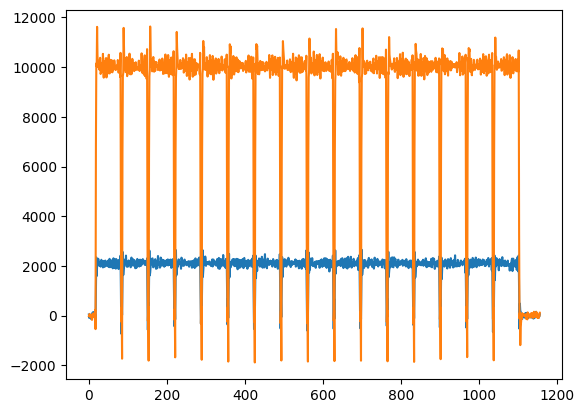

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
n=16 # WaveChunk は 16 個まで
for _ in range(n):
    w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=1,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=(n+1)*17, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]... 16 words の倍数

setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)

d = be.standalone_send_recv(*setup,trig=qube.port0.awg0,timeout=10)

plt.plot(np.real(d[qube.port1.capt.unit0]))
plt.plot(np.imag(d[qube.port1.capt.unit0]))
plt.show()

### num_wait_words の働き

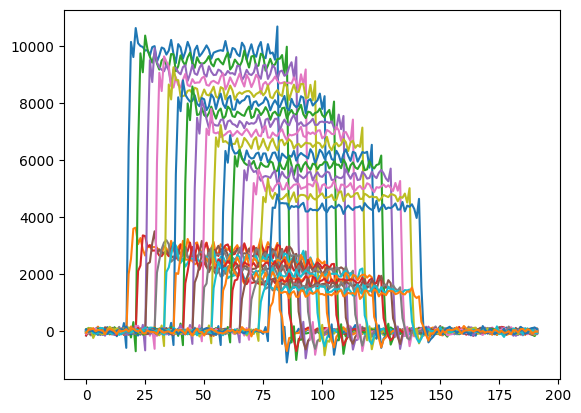

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

for i in range(16):

    w = e7awgsw.WaveSequence(num_wait_words=i,num_repeats=1) # 1 word = 4 samples = 8 ns
    w.add_chunk(iq_samples=64*[(int((0.05-0.03*i/16)*32767),0),],num_blank_words=0,num_repeats=1)
    
    p = e7awgsw.CaptureParam()
    p.num_integ_sections = 1
    p.add_sum_section(num_words=3*16, num_post_blank_words=1)
    p.capture_delay = 7*16 # [words]
    
    setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)
    
    d = be.send_recv(*setup,trigs={qube:qube.port0.awg0},timeout=10)
    
    plt.plot(np.real(d[qube.port1.capt.unit0]))
    plt.plot(np.imag(d[qube.port1.capt.unit0]))
    
plt.show()

### Numpy.ndarray で iq データを与えたい
e7awgsw.IqWave.gen_samples は 128ns (16 words) の整数倍になるように勝手にパディングしてしまうので注意．以下の conv_iqsamples はアライメントが取れていない場合にはエラーを出すようにしている．

In [24]:
import numpy as np

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

iq = np.ones(16*4).astype(complex)
conv_iqsamples(32767 * iq)

[(32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0)]

In [51]:
# 各種定数
# サンプリングレート
import e7awgsw

int(e7awgsw.AwgCtrl.SAMPLING_RATE / 1e+6) # Msps
# ps

500

### capture_delay の働き
16 * n + 4 words がアライメントの境界なので，delay 調整の際には注意すること．1 word 変化させてもパルスの観測位置が変化しないことがままある．16 words で変化させるのが吉だが，4 words のオフセットが入っているのは知っておいてもいいかも．
オフセット値が変わることもありそう...

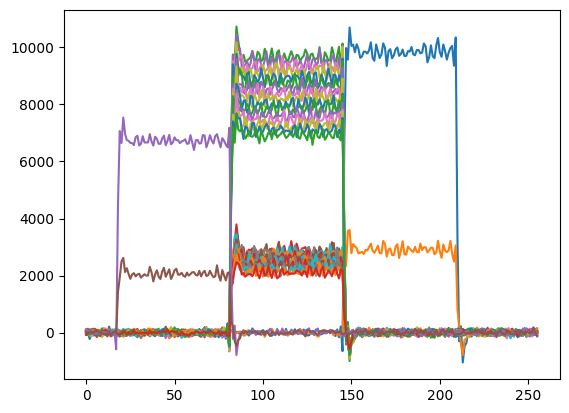

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

for i in range(18):

    w = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
    w.add_chunk(iq_samples=64*[(int((0.05-0.03*i/32)*32767),0),],num_blank_words=0,num_repeats=1)
    
    p = e7awgsw.CaptureParam()
    p.num_integ_sections = 1
    p.add_sum_section(num_words=4*16, num_post_blank_words=1)
    # p.capture_delay = 4 + 16 * 5 + i # [words] 16 * n + 4 words がアライメントの境界 2023/06/20
    p.capture_delay = 10 + 16 * 5 + i # [words] 16 * n + 4 words がアライメントの境界 2023/06/27
    
    setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)
    
    d = be.send_recv(*setup,trigs={qube:qube.port0.awg0},timeout=10)
    
    plt.plot(np.real(d[qube.port1.capt.unit0]))
    plt.plot(np.imag(d[qube.port1.capt.unit0]))
    
plt.show()

# 応用編

## 積算測定
反復測定したデータを重ねる処理

### ！！！ハマりどころ！！！
CaptureParam の num_post_blank_words は WaveChunk の num_blank_words と異なり，0 は受け付けられないので注意．積算測定でアライメントをとる際には num_workds + num_post_blank_words が 16 words の整数倍になるようにしないと観測範囲がズレるので注意．

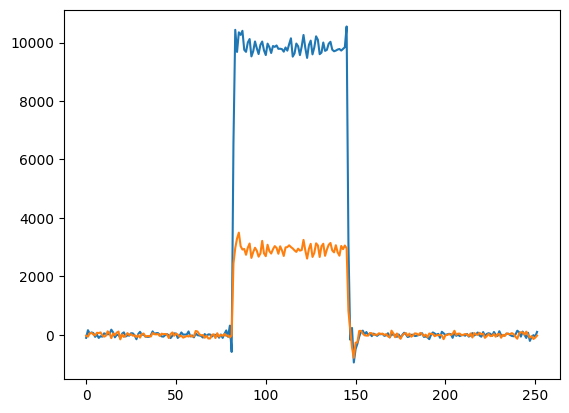

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

for i in range(1):

    w = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
    w.add_chunk(iq_samples=64*[(int((0.05-0.03*i/32)*32767),0),],num_blank_words=0,num_repeats=1)
    
    p = e7awgsw.CaptureParam()
    p.num_integ_sections = 1
    p.add_sum_section(num_words=4*16 - 1, num_post_blank_words=1)
    p.capture_delay = 4 + 16 * 6 # [words] 16 * n + 4 words がアライメントの境界
    
    setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)
    
    d = be.send_recv(*setup,trigs={qube:qube.port0.awg0},timeout=10)
    
    plt.plot(np.real(d[qube.port1.capt.unit0]))
    plt.plot(np.imag(d[qube.port1.capt.unit0]))
    
plt.show()

## 総和測定
ある区間にわたるデータの総和をとる

### LO の再設定で位相関係は変化するのか？
lo は再設定しても位相は揃っている．

In [97]:
import qubecalib as qc

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


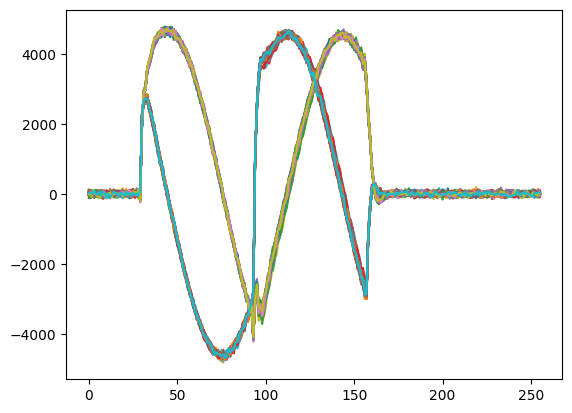

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

num_repeats = 50

iq = np.ones(16*4).astype(complex)
m = qube1.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)

iq = np.ones(16*4).astype(complex)
m = qube2.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 1
p1.add_sum_section(num_words=64, num_post_blank_words=1)
p1.capture_delay = 8*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=64, num_post_blank_words=1)
p2.capture_delay = 8*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    # (qube1.port12.capt.unit0, p2),
)

rets = {k:[] for k,v in setup if isinstance(k,qc.qube.UNIT)}
for i in tqdm.tqdm(range(num_repeats)):
    # ========================
    qube2.port0.lo.mhz = 12000
    # ========================
    with redirect_stdout(open(os.devnull, 'w')):
        d = be.send_recv(*setup,delay=0.2)
        for k,v in d.items():
            rets[k].append(v)

offset = 64
for k, v in rets.items():
    for o in v:
        plt.plot(np.real(o))
        plt.plot(np.imag(o))
plt.show()


### cnco の再設定で位相関係は変化するのか？
cnco を再設定すると位相が二つの値を行ったり来たりする．

In [45]:
import qubecalib as qc

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.54it/s]


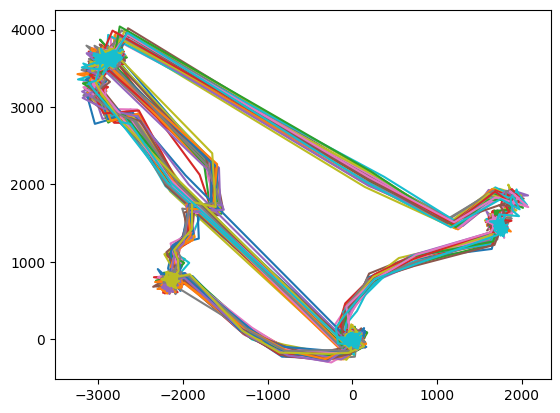

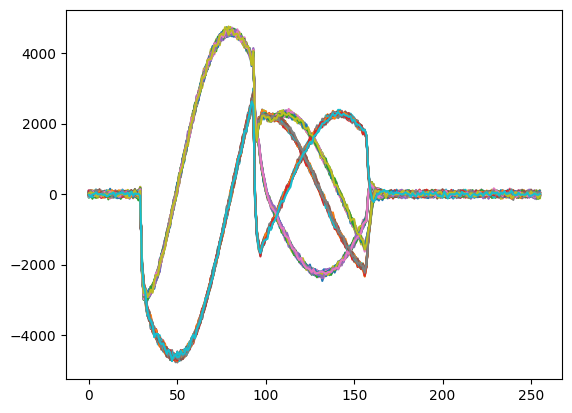

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

num_repeats = 50

iq = np.ones(16*4).astype(complex)
m = qube1.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)

iq = np.ones(16*4).astype(complex)
m = qube2.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.025 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 1
p1.add_sum_section(num_words=64, num_post_blank_words=1)
p1.capture_delay = 8*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=64, num_post_blank_words=1)
p2.capture_delay = 8*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    # (qube1.port12.capt.unit0, p2),
)

rets = {k:[] for k,v in setup if isinstance(k,qc.qube.UNIT)}
for i in tqdm.tqdm(range(num_repeats)):
    # ========================
    qube2.port0.nco.mhz = 2000
    # ========================
    with redirect_stdout(open(os.devnull, 'w')):
        d = be.send_recv(*setup,delay=0.2)
        for k,v in d.items():
            rets[k].append(v)

offset = 64
for k, v in rets.items():
    for o in v:
        m = k.capt.modulation_frequency(mhz=9996) # mhz
        t = np.arange(0,len(o)) * 2 # sampling points [ns]
        o *= np.exp(-1j*2*np.pi*m*t*1e+6*1e-9)
        plt.plot(np.real(o), np.imag(o))
        # plt.plot(np.real(o))
        # plt.plot(np.imag(o))
plt.show()
for k, v in rets.items():
    for o in v:
        m = k.capt.modulation_frequency(mhz=9996) # mhz
        t = np.arange(0,len(o)) * 2 # sampling points [ns]
        o *= np.exp(-1j*2*np.pi*m*t*1e+6*1e-9)
        # plt.plot(np.real(o), np.imag(o))
        plt.plot(np.real(o))
        plt.plot(np.imag(o))
plt.show()

## DSP の活用

### Dsp Unit を Disabled して積算区間（繰り返し）を16個，総和区間を2個．

`e7awgsw.CaptureCtrl.get_capture_data(unit, nsamples)` は以下の連続したデータを返す．

```
   [積算区間 0 総和区間 0 のデータ][積算区間 0 総和区間 1 のデータ]...
...[積算区間 1 総和区間 0 のデータ][積算区間 1 総和区間 1 のデータ]...
```

積算区間毎のデータは同じ個数であるが，それぞれの総和区間のデータは異なる個数であり得る．

`reshape` で積算区間毎に２次元配列に直したあと，`hsplit` で総和区間毎に分割したリストにする．
`matplotlib` での利便性を考えて，第一引数に `index` がくるように `transpose` する．

各々の総和区間に対して `サンプル数 x 積算区間数` の `Dimension` の `ndarray` が作られて，リスト化されて帰ってくる．

以下は各総和区間毎に実部，虚部を積算区間本数分だけプロットしたグラフを描画するコード．
```
d = qubecalib.backendqube.send_recv(...)
for o in d:
    plt.plot(np.real(o))
    plt.plot(np.imag(o))
    plt.show()
```

In [6]:
list(be.split_qube(*setup).keys())[0]

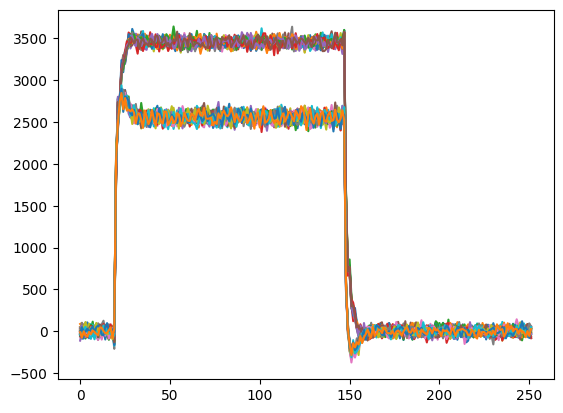

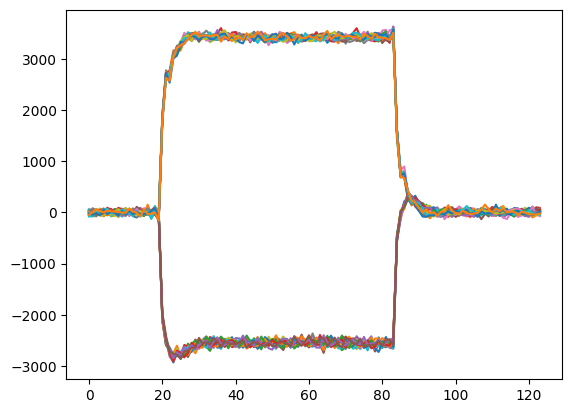

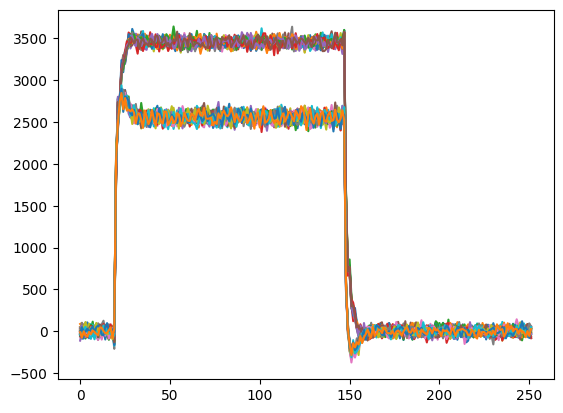

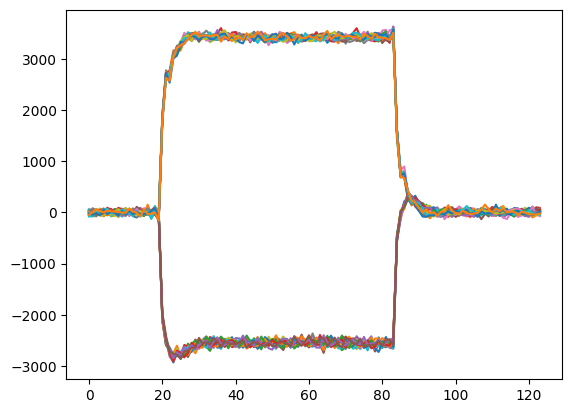

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=16) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 16
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    # e7awgsw.DspUnit.SUM,
    # e7awgsw.DspUnit.INTEGRATION,
    # e7awgsw.DspUnit.CLASSIFICATION,
)

a = qube.port0.awg0.id
u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[:2]
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    cc.initialize(*u)
    for uu in u:
        cc.set_capture_params(uu, p)
    cc.select_trigger_awg(qube.port1.capt.id,qube.port0.awg0.id)
    cc.enable_start_trigger(*u)
    
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    
    cc.wait_for_capture_units_to_stop(10, *u)
    cc.check_err(*u)

    rslt = {}
    l = p.num_integ_sections
    m = len(p.sum_section_list)
    for uu in u:
        n = cc.num_captured_samples(uu)
        c = np.array(cc.get_capture_data(uu,n))
        d = c[:,0] + 1j * c[:,1]
        d = d.reshape(l, -1)
        d = np.hsplit(d, [w * p.NUM_SAMPLES_IN_ADC_WORD for w,b in p.sum_section_list[:-1]])
        d = [di.transpose() for di in d]
        rslt[uu] = d

for k, v in rslt.items():
    for di in v:
        plt.plot(np.real(di))
        plt.plot(np.imag(di))
        plt.show()
pass

(252, 16)


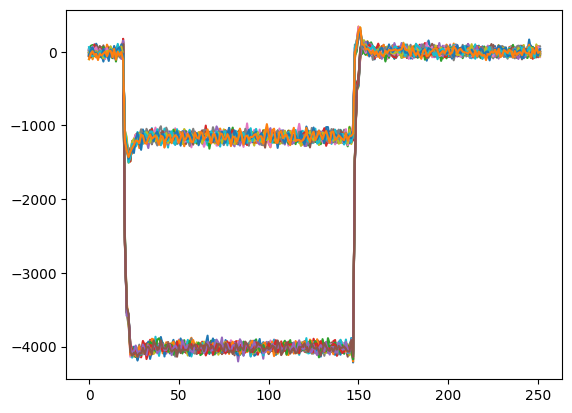

(124, 16)


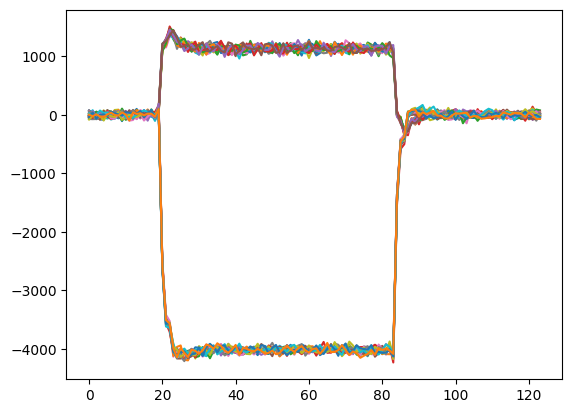

(252, 16)


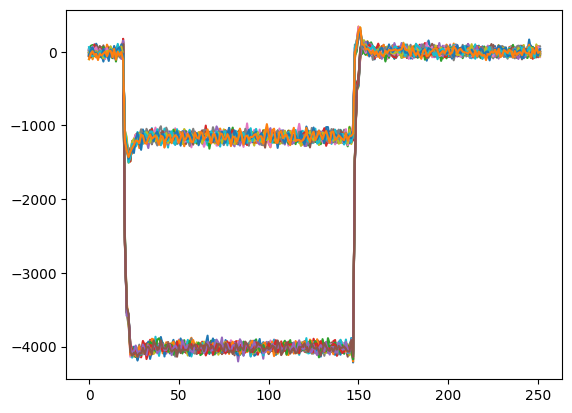

(124, 16)


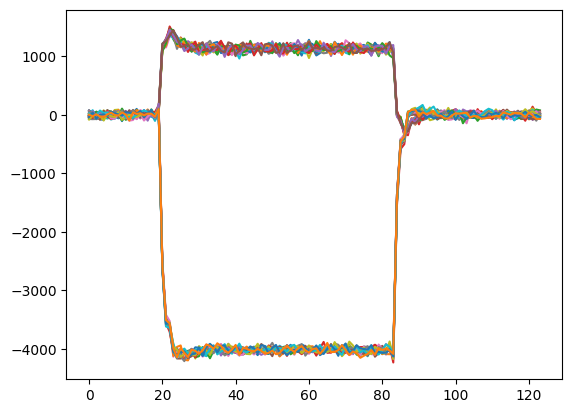

(252, 16)


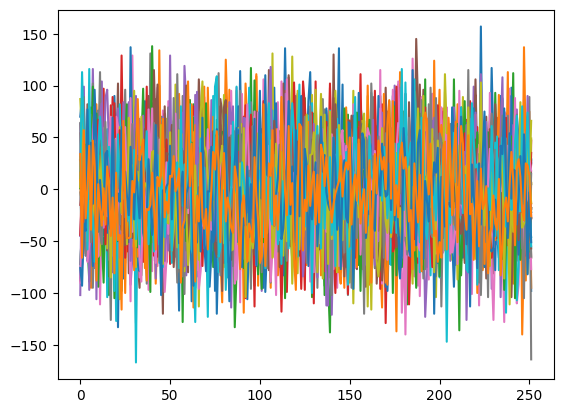

(124, 16)


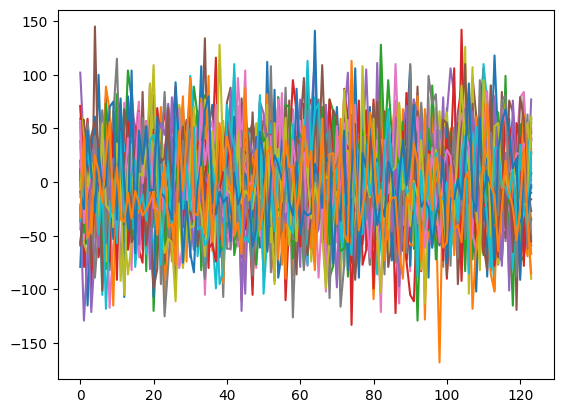

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=16) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 16
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    # e7awgsw.DspUnit.SUM,
    # e7awgsw.DspUnit.INTEGRATION,
    # e7awgsw.DspUnit.CLASSIFICATION,
)

setup = (
    (qube.port0.awg0, w),
    (qube.port1.capt.unit0, p),
    (qube.port1.capt.unit1, p),
    (qube.port12.capt.unit0, p),
)
r = be.send_recv(*setup)

for k, v in r.items():
    for vv in v:
        print(vv.shape)
        plt.plot(np.real(vv))
        plt.plot(np.imag(vv))
        plt.show()
pass

### 積算を有効化して積算区間（繰り返し）を16個，総和区間を2個．

積算したので，各総和区間には１本のグラフしか描画されない．

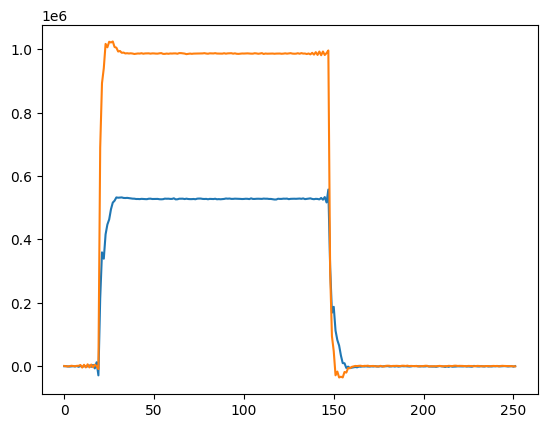

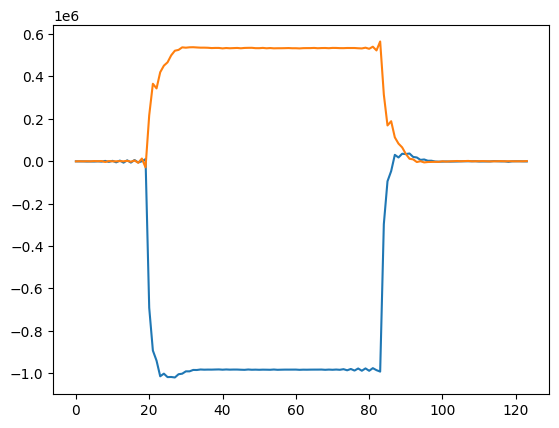

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=256) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)


p = e7awgsw.CaptureParam()
p.num_integ_sections = 256
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    # e7awgsw.DspUnit.SUM,
    e7awgsw.DspUnit.INTEGRATION,
    # e7awgsw.DspUnit.CLASSIFICATION,
)

a = qube.port0.awg0.id
u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    cc.initialize(u)
    cc.set_capture_params(u, p)
    cc.select_trigger_awg(qube.port1.capt.id,qube.port0.awg0.id)
    cc.enable_start_trigger(u)
    
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    
    cc.wait_for_capture_units_to_stop(10, u)
    cc.check_err(u)
    
    l = p.num_integ_sections
    m = len(p.sum_section_list)
    n = cc.num_captured_samples(u)
    c = np.array(cc.get_capture_data(u,n))
    d = c[:,0] + 1j * c[:,1]
    d = d.reshape(1, -1) # <===
    d = np.hsplit(d, [w * p.NUM_SAMPLES_IN_ADC_WORD for w,b in p.sum_section_list[:-1]])
    d = [di.transpose() for di in d]

for di in d:
    plt.plot(np.real(di))
    plt.plot(np.imag(di))
    plt.show()
pass


(252, 1)


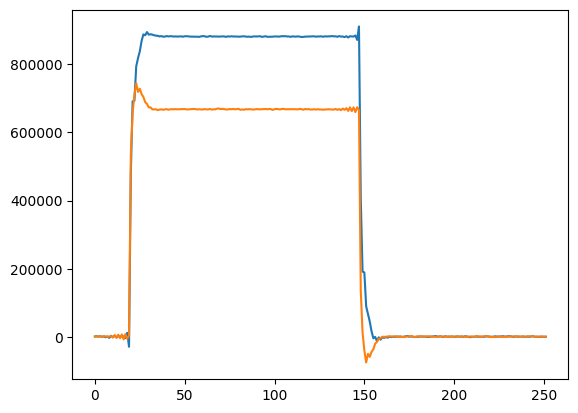

(124, 1)


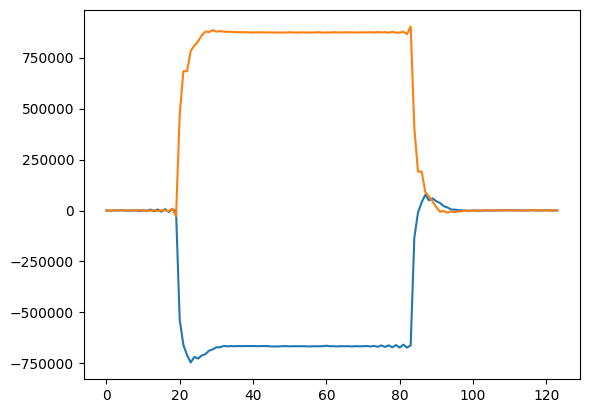

(252, 1)


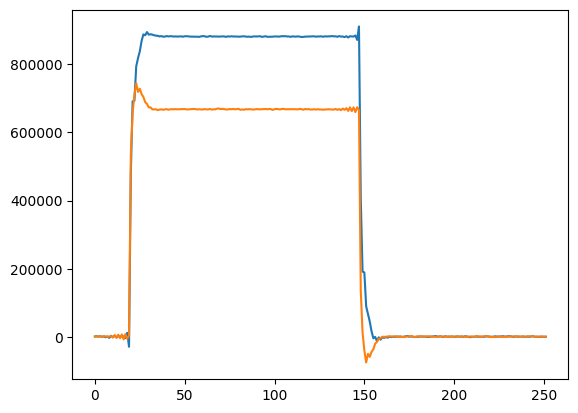

(124, 1)


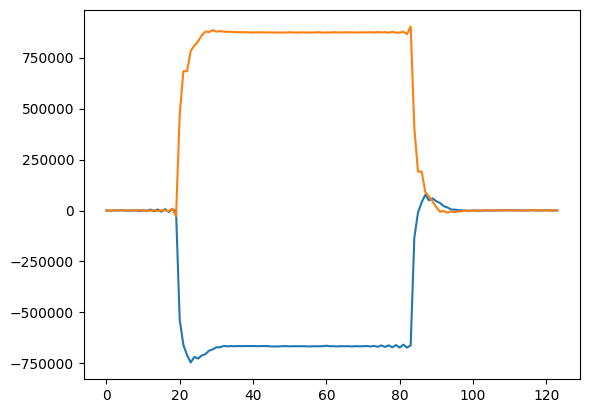

(252, 1)


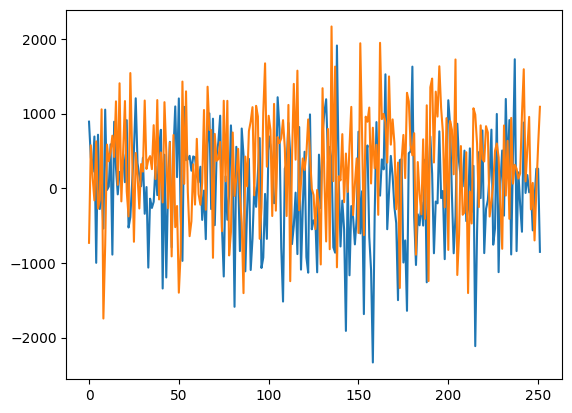

(124, 1)


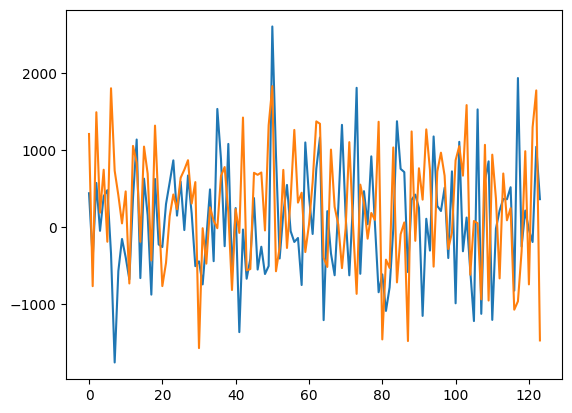

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=256) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)


p = e7awgsw.CaptureParam()
p.num_integ_sections = 256
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    # e7awgsw.DspUnit.SUM,
    e7awgsw.DspUnit.INTEGRATION,
    # e7awgsw.DspUnit.CLASSIFICATION,
)

setup = (
    (qube.port0.awg0, w),
    (qube.port1.capt.unit0, p),
    (qube.port1.capt.unit1, p),
    (qube.port12.capt.unit0, p),
)
r = be.send_recv(*setup)

for k, v in r.items():
    for vv in v:
        print(vv.shape)
        plt.plot(np.real(vv))
        plt.plot(np.imag(vv))
        plt.show()
pass


### 加算を有効化して積算区間（繰り返し）を16個，総和区間を2個．

加算したのでサンプル数１の値が１６個得られる．他の設定との互換性のため，縦ベクトルで得られる．

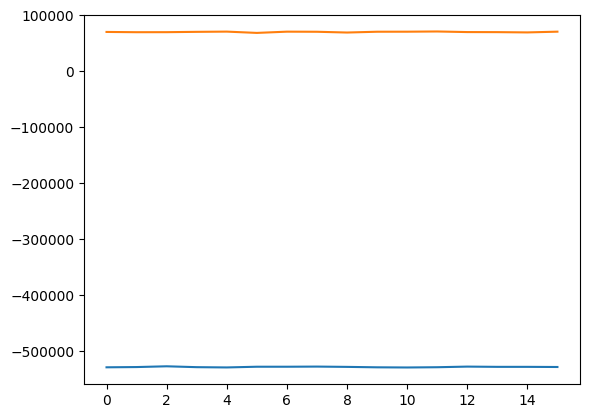

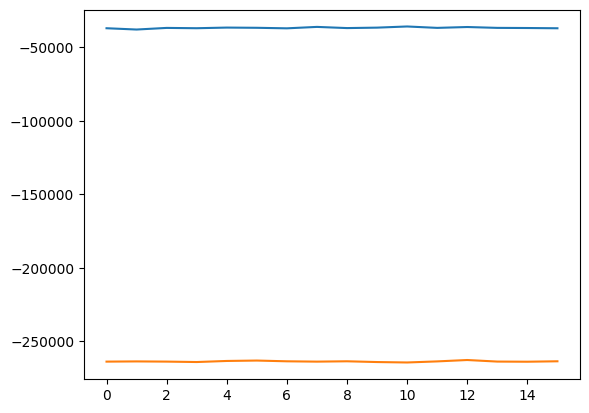

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=16) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 16
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    e7awgsw.DspUnit.SUM,
    # e7awgsw.DspUnit.INTEGRATION,
    # e7awgsw.DspUnit.CLASSIFICATION,
)

a = qube.port0.awg0.id
u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    cc.initialize(u)
    cc.set_capture_params(u, p)
    cc.select_trigger_awg(qube.port1.capt.id,qube.port0.awg0.id)
    cc.enable_start_trigger(u)
    
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    
    cc.wait_for_capture_units_to_stop(10, u)
    cc.check_err(u)
    
    l = p.num_integ_sections
    m = len(p.sum_section_list)
    n = cc.num_captured_samples(u)
    c = np.array(cc.get_capture_data(u,n))
    d = c[:,0] + 1j * c[:,1]
    d = d.reshape(l, -1)
    d = np.hsplit(d, list(range(m)[1:]))

print()

for di in d:
    plt.plot(np.real(di))
    plt.plot(np.imag(di))
    plt.show()
pass

(16, 1)


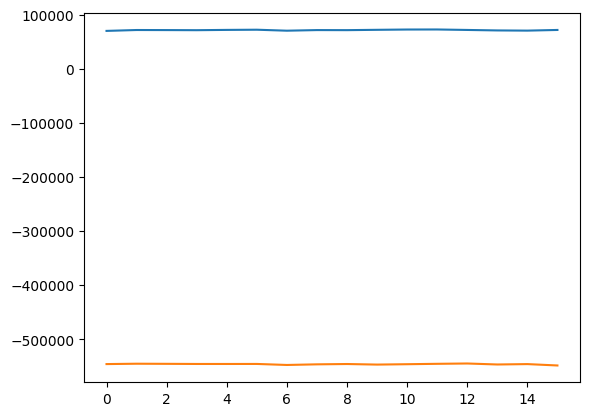

(16, 1)


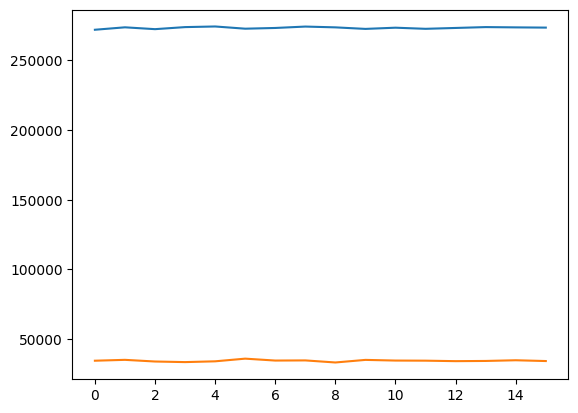

(16, 1)


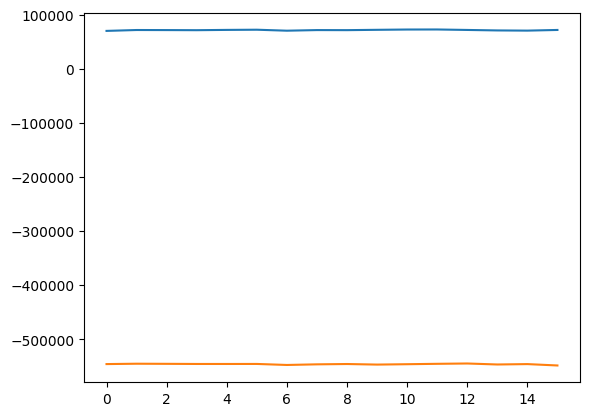

(16, 1)


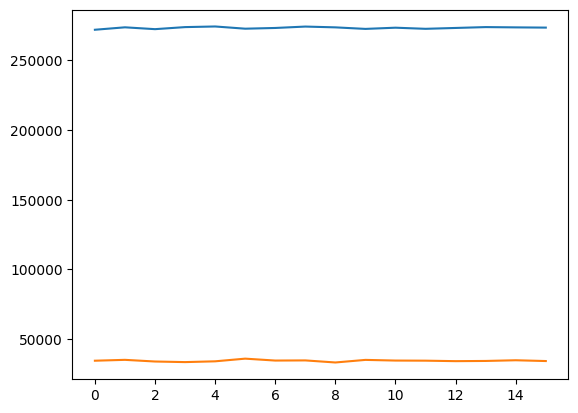

(16, 1)


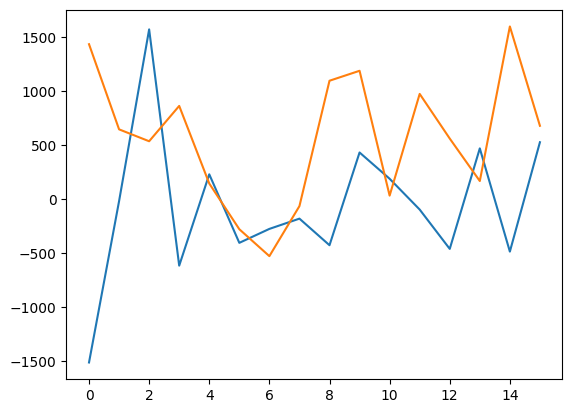

(16, 1)


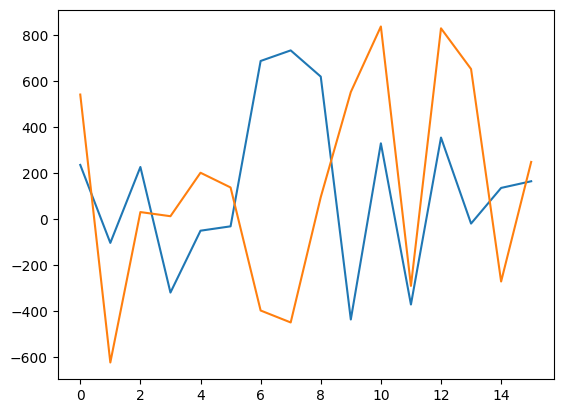

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=16) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 16
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    e7awgsw.DspUnit.SUM,
    # e7awgsw.DspUnit.INTEGRATION,
    # e7awgsw.DspUnit.CLASSIFICATION,
)

setup = (
    (qube.port0.awg0, w),
    (qube.port1.capt.unit0, p),
    (qube.port1.capt.unit1, p),
    (qube.port12.capt.unit0, p),
)
r = be.send_recv(*setup)

for k, v in r.items():
    for vv in v:
        print(vv.shape)
        plt.plot(np.real(vv))
        plt.plot(np.imag(vv))
        plt.show()
pass

### 四値化を有効化して積算区間（繰り返し）を16個，総和区間を2個．

得られるデータが判別後の id になっている．積算や加算を実行したときは前述と同様の振る舞いをする．

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=16) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 16
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    # e7awgsw.DspUnit.SUM,
    # e7awgsw.DspUnit.INTEGRATION,
    e7awgsw.DspUnit.CLASSIFICATION,
)

a = qube.port0.awg0.id
u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    cc.initialize(u)
    cc.set_capture_params(u, p)
    cc.select_trigger_awg(qube.port1.capt.id,qube.port0.awg0.id)
    cc.enable_start_trigger(u)
    
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    
    cc.wait_for_capture_units_to_stop(10, u)
    cc.check_err(u)

    # cc.wait_for_capture_units_to_stop(10, u)
    # cc.check_err(u)
    
    l = p.num_integ_sections
    m = len(p.sum_section_list)
    n = cc.num_captured_samples(u)
    d = np.array(list(cc.get_classification_results(u,n)))
    d = d.reshape(l, -1)
    d = np.hsplit(d, [w * p.NUM_SAMPLES_IN_ADC_WORD for w,b in p.sum_section_list[:-1]])
    d = [di.transpose() for di in d]

print(len(d),[i.shape for i in d])
for i in d:
    print(i)

2 [(252, 16), (124, 16)]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.gpio.write_value(0x0000) # Output
ptx = qube.port0
ptx.lo.mhz = 8000
ptx.nco.mhz = 2000
ptx.mix.vatt = 0x800
prx = qube.port1
prx.nco.mhz = 2000

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=16) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=128*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=64*[(0,int(0.05*32767)),],num_blank_words=16,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 16
p.add_sum_section(num_words=63, num_post_blank_words=1)
p.add_sum_section(num_words=31, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...
p.sel_dsp_units_to_enable(
    # e7awgsw.DspUnit.COMPLEX_FIR,
    # e7awgsw.DspUnit.DECIMATION,
    # e7awgsw.DspUnit.REAL_FIR,
    # e7awgsw.DspUnit.COMPLEX_WINDOW,
    # e7awgsw.DspUnit.SUM,
    # e7awgsw.DspUnit.INTEGRATION,
    e7awgsw.DspUnit.CLASSIFICATION,
)

setup = (
    (qube.port0.awg0, w),
    (qube.port1.capt.unit0, p),
    (qube.port1.capt.unit1, p),
    (qube.port12.capt.unit0, p),
)
r = be.send_recv(*setup)

for k, v in r.items():
    print(len(v),[vv.shape for vv in v])
    for vv in v:
        print(vv)

2 [(252, 16), (124, 16)]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2 [(252, 16), (124, 16)]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2 [(252, 16), (124, 16)]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Rabi 振動の観測

## 複数機を使用した時の位相

```
Readout --[  ]--
Readout --[][]--

Readout --[]----
Ctrl    ----[]--
```

## 多重化

位相関係を保証したい．多分ここは qube-calib で隠蔽しないとユーザが厳しい．

In [5]:
import qubecalib as qc

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.nco.mhz = 2000

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.nco.mhz = 2000


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]

integ_section: 0


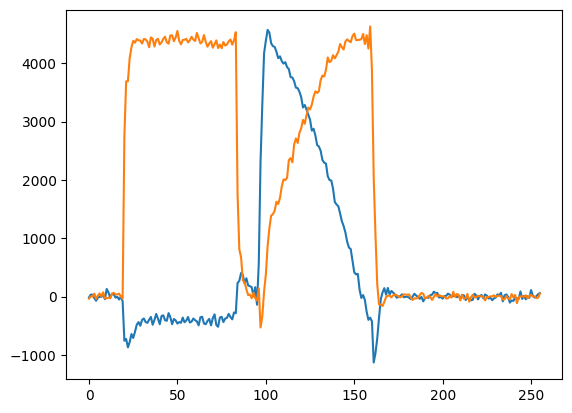

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

pt = qube1.port0
pt.lo.mhz = 8000
pt.mix.vatt = 0x800

pt = qube2.port0
pt.lo.mhz = 12000
pt.mix.vatt = 0xA00

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

num_repeats = 1

iq = np.ones(16*4).astype(complex)
m = qube1.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]
iq *= np.exp(1j*2*np.pi*m*t*1e+6*1e-9)

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w1 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)

iq = np.ones(16*4).astype(complex)
m = qube2.port0.awg0.modulation_frequency(mhz=9998) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]
iq *= np.exp(1j*2*np.pi*m*t*1e+6*1e-9)

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w2 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 1
p1.add_sum_section(num_words=64, num_post_blank_words=1)
p1.capture_delay = 7*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=64, num_post_blank_words=1)
p2.capture_delay = 7*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    # (qube1.port12.capt.unit0, p2),
)

rets = {}
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        r = be.send_recv(*setup,delay=0.2)
        for k, v in r.items():
            if k in rets:
                rets[k] = [np.dstack([rr, vv]) for vv, rr in zip(v,rets[k])]
            else:
                rets[k] = [vv.reshape(vv.shape[0], 1, vv.shape[1]) for vv in v]

qube1.port1.capt.ssb = qc.qube.SSB.USB
for k, v in rets.items():
    m = k.capt.modulation_frequency(mhz=9996)
    for vv in v: # for sum_section loop
        t = np.arange(0,vv.shape[0]) * 2 # timestamp [ns]
        d = np.exp(-1j*2*np.pi*(m*1e+6)*(t*1e-9))
        d = d.reshape(vv.shape[0],vv.shape[2])
        for j in range(vv.shape[1]): # for integ_section loop
            print('integ_section:', j)
            plt.plot(np.real(vv[:,j,:] * d))
            plt.plot(np.imag(vv[:,j,:] * d))
            plt.show()


#### qube-calib の実装

-10000000.0 [0.00e+00 2.00e-09 4.00e-09 6.00e-09 8.00e-09 1.00e-08 1.20e-08 1.40e-08
 1.60e-08 1.80e-08 2.00e-08 2.20e-08 2.40e-08 2.60e-08 2.80e-08 3.00e-08
 3.20e-08 3.40e-08 3.60e-08 3.80e-08 4.00e-08 4.20e-08 4.40e-08 4.60e-08
 4.80e-08 5.00e-08 5.20e-08 5.40e-08 5.60e-08 5.80e-08 6.00e-08 6.20e-08
 6.40e-08 6.60e-08 6.80e-08 7.00e-08 7.20e-08 7.40e-08 7.60e-08 7.80e-08
 8.00e-08 8.20e-08 8.40e-08 8.60e-08 8.80e-08 9.00e-08 9.20e-08 9.40e-08
 9.60e-08 9.80e-08 1.00e-07 1.02e-07 1.04e-07 1.06e-07 1.08e-07 1.10e-07
 1.12e-07 1.14e-07 1.16e-07 1.18e-07 1.20e-07 1.22e-07 1.24e-07 1.26e-07]


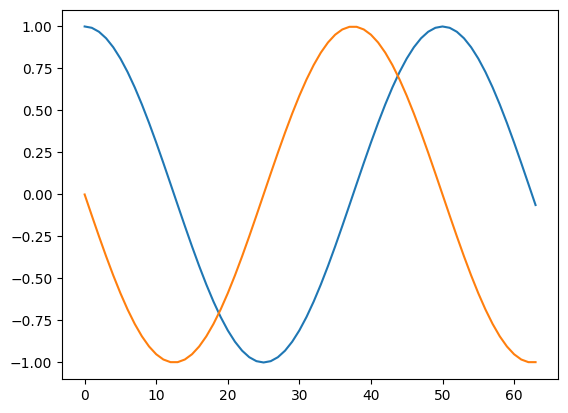

-10

In [107]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import qubecalib as qc
import e7awgsw
from typing import Final

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = qc.meas.WaveSequenceFactory(num_wait_words=0, num_repeats=1)
w.new_chunk(duration=128e-9, amp=32767, blank=0, repeats=1, init=0)
w.chunk[-1].iq

class Slot(object):
    
    SAMPLING_RATE = e7awgsw.AwgCtrl.SAMPLING_RATE # Hz
    SAMPLING_PERIOD = int(1 / SAMPLING_RATE * 1_000_000_000) # ns
    SAMPLES_PER_WORD = 4
    WORDS_PER_ALIGNMENT = 16 # アライメントが取れるワード長
    
    duration_ns: Final[int]
    duration_alignment: Final[int]
    duration_words: Final[int]
    duration_samples: Final[int]
    
    def __init__(self,start_ns=0,duration_ns=128):

        self.start_ns = start_ns
        self.duration_ns = duration_ns
        # q ,r = divmod(duration_ns, self.WORDS_PER_ALIGNMENT * self.SAMPLES_PER_WORD * self.SAMPLING_PERIOD)
        # if r != 0:
        #     raise Exception('The duration must be an integer multiple of 128.')
        # self.duration_alignment = q
        self.duration_words = nw = q * self.WORDS_PER_ALIGNMENT
        self.duration_samples = nw * self.SAMPLES_PER_WORD
        
class Arbit(Slot):
    
    def __init__(self,start_ns=0,duration_ns=128,init=0+0j):

        super().__init__(duration_ns)
        self.iq = np.zeros(self.duration_samples).astype(complex) # iq data
    
    @property
    def sampling_points_ns(self):
        return np.arange(0,len(self.iq)) * 2 # sampling points [ns]

class Channel(list):
    
    def __init__(self, mhz, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.mhz = mhz

    def append(self, *x):

        for i in x:
            super().append(i)

        return x[0]

    def __lshift__(self, slot):
        
        super().append(slot)
        
        return self
    
class RxChannel(Channel):

    pass

class Read(object):

    def __init__(self,duration_ns=128+64,advance_ns=64):

        pass



c1 = Channel(mhz=9990)
c1.append(Blank(128))
a1 = c1.append(Arbit(128))
c2 = Channel(mhz=9990)
a2 = c2.append(Arbit(128))
c3 = RxChannel(mhz=9990)
c3.append(*[Blank(128),Read(128+64,64)])

m = qube.port0.awg0.modulation_frequency(mhz=9990) # mhz
t = a1.sampling_points_ns
7_812_500 # hz
print(m*1e+6,t*1e-9)

d = np.exp(1j*2*np.pi*(m*t)*(1e+6*1e-9))

plt.plot(np.real(d))
plt.plot(np.imag(d))
plt.show()

m = qube.port1.capt.modulation_frequency(mhz=9990) # mhz
m
qube.port1.capt.ssb = qc.qube.SSB.USB
qube.port1.capt.modulation_frequency(mhz=9990)


## 単発射影測定

# その他諸々

## qubelsi の参照先
`submodule` として `qube-calib` 以下にインストールしていたが，何かと弊害が多いと町野さんから教えてもらったので，（`Pipfile` を使う方法が良さげとのこと）とりあえず qube-calib の兄弟として qubelsi をインストールして利用する設定にした．もっといい方法ありそうだけど．

# qubecalib.pulse の新しい実装

section
<qubecalib.qube.AWG object at 0x7f6b7535e3a0>: deque([<__main__.Chunk object at 0x7f6b8c470d90>, <__main__.Chunk object at 0x7f6b8c4701f0>]) [(0.0, 256.0), (384.0, 256.0)]
<qubecalib.qube.AWG object at 0x7f6b396a7b50>: deque([<__main__.Chunk object at 0x7f6b8c470cd0>, <__main__.Chunk object at 0x7f6b8c470d60>]) [(0.0, 256.0), (384.0, 256.0)]
<qubecalib.qube.UNIT object at 0x7f6b396a7ee0>: deque([<__main__.Section object at 0x7f6b8c470e50>, <__main__.Section object at 0x7f6b8c470070>]) [(40.0, 256.0), (440.0, 256.0)]
<qubecalib.qube.UNIT object at 0x7f6b396a7610>: deque([<__main__.Section object at 0x7f6b8c470370>]) [(40.0, 256.0)]
channel->slots
<__main__.Control object at 0x7f6b75340c70>: deque([<__main__.Arbit object at 0x7f6b74644460>, <__main__.Arbit object at 0x7f6b7544a5b0>])
<__main__.Readout object at 0x7f6b75340370>: deque([<__main__.Arbit object at 0x7f6b746442e0>, <__main__.Range object at 0x7f6b74644340>, <__main__.Arbit object at 0x7f6b7544a8e0>, <__main__.Range ob

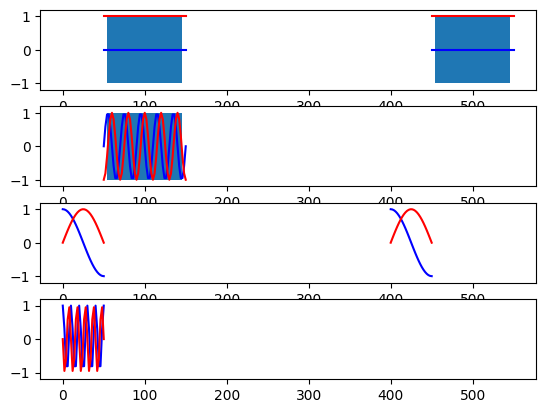

awg/unit->sections
{<qubecalib.qube.AWG object at 0x7f6b7535e3a0>: deque([<__main__.Chunk object at 0x7f6b8c470d90>, <__main__.Chunk object at 0x7f6b8c4701f0>]), <qubecalib.qube.AWG object at 0x7f6b396a7b50>: deque([<__main__.Chunk object at 0x7f6b8c470cd0>, <__main__.Chunk object at 0x7f6b8c470d60>]), <qubecalib.qube.UNIT object at 0x7f6b396a7ee0>: deque([<__main__.Section object at 0x7f6b8c470e50>, <__main__.Section object at 0x7f6b8c470070>]), <qubecalib.qube.UNIT object at 0x7f6b396a7610>: deque([<__main__.Section object at 0x7f6b8c470370>])}
section->slots
{<__main__.Chunk object at 0x7f6b8c470d90>: deque([<__main__.Arbit object at 0x7f6b74644460>, <__main__.Arbit object at 0x7f6b7544a4c0>]), <__main__.Chunk object at 0x7f6b8c4701f0>: deque([<__main__.Arbit object at 0x7f6b7544a5b0>]), <__main__.Chunk object at 0x7f6b8c470cd0>: deque([<__main__.Arbit object at 0x7f6b746442e0>, <__main__.Arbit object at 0x7f6b8c4704c0>]), <__main__.Chunk object at 0x7f6b8c470d60>: deque([<__main__.

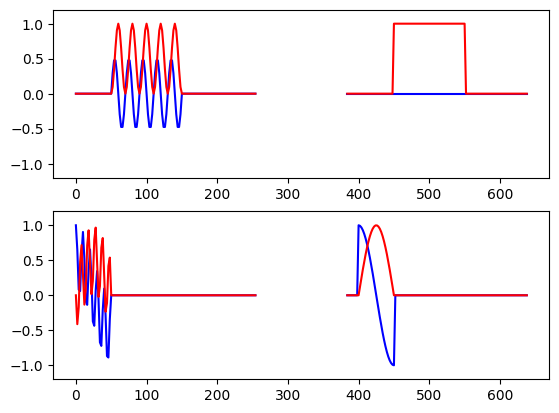

WaveSequence
[(<qubecalib.qube.AWG object at 0x7f6b396a7b50>, <e7awgsw.wavesequence.WaveSequence object at 0x7f6b7533a6a0>), (<qubecalib.qube.AWG object at 0x7f6b7535e3a0>, <e7awgsw.wavesequence.WaveSequence object at 0x7f6b74cd0e80>)]


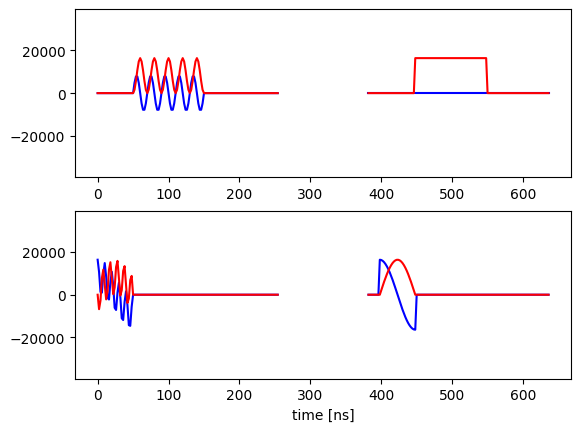

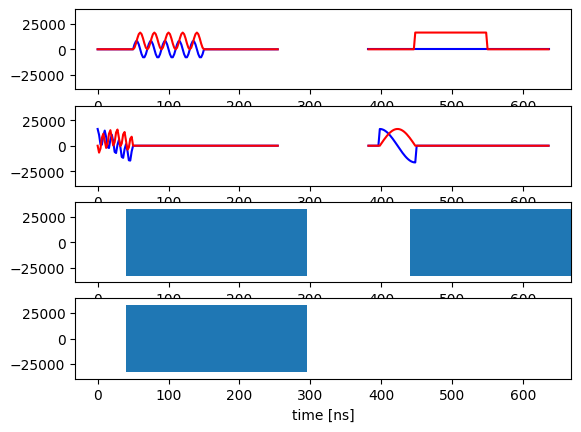

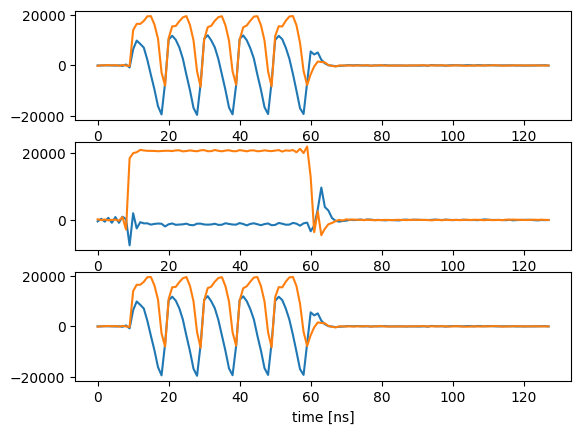

In [8]:
from contextlib import contextmanager
from collections import namedtuple, deque
import numpy as np
import math
import e7awgsw
from typing import Final, TypedDict

# 時間の内部単位は ns
# 周波数の内部単位は GHz

RunningConfig = namedtuple(
    'RunningConfig',
    [
        'contexts',
    ]
)
RunningConfig.__new__.__defaults__ = (deque(),)
__rc__: Final[RunningConfig] = RunningConfig()

mS: Final[float] = 1e+6
uS: Final[float] = 1e+3
nS: Final[float] = 1.

MHz: Final[float] = 1e-3
GHz: Final[float] = 1.
BLOCK: Final[float] = 128.
BLOCKs: Final[float] = BLOCK
WORD: Final[float] = 8.
WORDs: Final[float] = WORD

class Channel(object):

    def __init__(self,frequency,*args,**kw):

        super().__init__(*args,**kw)
        self.frequency = frequency
        

class Control(Channel): pass
class Readout(Channel): pass


class ContextNode(object):

    def __init__(self):
        c = __rc__.contexts
        if len(c):
            c[-1].append(self)

class Slot(ContextNode):

    SAMPLING_PERIOD: Final[float] = 2.

    def __init__(self,ch,begin=0*nS,width=64*nS):

        super().__init__()
        self.ch = ch
        self.begin = begin
        self.width = width
        self.reset()

    def reset(self):
        for x in [self.begin,self.width]:
            q ,r = divmod(x, self.SAMPLING_PERIOD)
            if r != 0:
                raise Exception('The specified time must be a multiple of {} ns.')
        self.width_in_samples = int(self.width / self.SAMPLING_PERIOD) + 1
        
    def set(self,**kw):

        for k,v in kw.items():
            setattr(self,k,v)
        self.reset()

class Arbit(Slot):

    def __init__(self,ch,begin=0*nS,width=64*nS,init=0+0j):

        self.init = init
        self.miq = None
        super().__init__(ch,begin,width)

    def reset(self):
        super().reset()
        self.iq = np.zeros(self.width_in_samples).astype(complex) # iq data
        self.iq[:] = self.init

    @property
    def sampling_points(self):

        return np.arange(0,len(self.iq)) * 2 + self.begin # sampling points [ns]
    
class Range(Slot):

    def __init__(self,ch,begin=0*nS,width=64*nS):

        super().__init__(ch,begin,width)

@contextmanager
def new_sequence():

    __rc__.contexts.append(deque())
    try:
        yield __rc__.contexts[-1]
    finally:
        __rc__.contexts.pop()

@contextmanager
def new_section():

    __rc__.contexts.append({})
    try:
        yield __rc__.contexts[-1]
    finally:
        __rc__.contexts.pop()


class ContextNodeAlloc(object):

    def __init__(
        self,
        begin,
        end=None,
        width=None
    ):
        
        self.begin = begin
        self._end_width(end,width)
        
    def _end_width(self,end,width):
        if width is None:
            self.end = end
            self.width = end - self.begin
        elif end is None:
            self.end = self.begin + width
            self.width = width
        else:
            raise()
        
    def alloc(self,*args):

        c = __rc__.contexts
        if len(c):
            d = c[-1]
            for a in args:
                if a not in d:
                    d[a] = deque([self.__class__(self.begin,self.end)])
                else:
                    d[a].append(self.__class__(self.begin,self.end))


class Chunk(ContextNodeAlloc):

    def __init__(
        self,
        begin,
        end=None,
        width=None
    ):

        super().__init__(begin,end,width)
        width_in_samples = n = int(self.width // 2)
        self.iq = np.zeros(n).astype(complex)
    
    @property
    def sampling_points(self):
        
        return np.arange(len(self.iq)) * 2 + self.begin # sampling points [ns]

class Section(ContextNodeAlloc): pass

class FDMA(object):
    pass


# -----
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import qutip

import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x800
qube.port1.nco.mhz = 2000
qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x800
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port5.mix.vatt = 0x800
qube.gpio.write_value(0xFFFF) # Loopback


def rabi_sequence(qch, rch, offset=0*nS):
    ctrl = Arbit(qch,begin=0*nS+offset,width=50*nS,init=1)
    read = Arbit(rch,begin=50*nS+offset,width=100*nS,init=1j)
    capt = Range(rch,begin=54*nS+offset,width=92*nS)
    return ctrl, read, capt
    
# 論理チャネルの割り当て
CQ1: Final[Control] = Control(9990*MHz)
RQ1: Final[Readout] = Readout(10000*MHz)
CQ2: Final[Control] = Control(10100*MHz)
RQ2: Final[Readout] = Readout(10050*MHz)

with new_sequence() as sequence:
    
    sq1c,sq1r,sq1o = rabi_sequence(CQ1,RQ1)
    rabi_sequence(CQ1,RQ1,offset=400*nS)
    sq2c,sq2r,sq2o = rabi_sequence(CQ2,RQ2)

# sq1c.set(start_ns=-4,duration_ns=4)
# print(sq1c.sampling_points_ns, sq1c.duration_samples)

# 物理チャネルに名前をつける（接続先）
MUX1TX: Final[qc.qube.Port] = qube.port0
MUX1RX: Final[qc.qube.Port] = qube.port1
TXQ1: Final[qc.qube.Port] = qube.port5
TXQ2: Final[qc.qube.Port] = qube.port6

# 物理チャネルへの論理チャネルの割り当て表
alloc_table = {
    MUX1TX.awg0: [RQ1,RQ2],
    MUX1RX.capt.unit0: [RQ1,],
    MUX1RX.capt.unit1: [RQ2,],
    TXQ1.awg0: [CQ1,CQ2],
}

with new_section() as section:

    Chunk(0*nS,256*nS).alloc(
        TXQ1.awg0,
        # TXQ2.awg0,
        MUX1TX.awg0,
    )
    Chunk(384*nS,640*nS).alloc(
        TXQ1.awg0,
        # TXQ2.awg0,
        MUX1TX.awg0,
    )
    Section(40*nS,width=2*BLOCK).alloc(
        MUX1RX.capt.unit0,
        MUX1RX.capt.unit1
    )
    Section(440*nS,width=2*BLOCK).alloc(
        MUX1RX.capt.unit0,
        # MUX1RX.capt.unit1
    )

print('section')
for k,v in section.items():
    print('{}: {}'.format(k,v),[(vv.begin,vv.width) for vv in v])

# Channel 毎に Slot をまとめる

def organize_slots(sequence):
    r = {}
    for v in sequence:
        if v.ch not in r:
            r[v.ch] = deque([v])
        else:
            r[v.ch].append(v)
    return r

channel2slot = r = organize_slots(sequence)


print('channel->slots')
for k,v in r.items():
    print('{}: {}'.format(k,v))

# チャネル対AWG/UNITの辞書を作る
def split_awg_unit(alloc_table):
    a,c = {},{}
    for k,v in alloc_table.items():
        for vv in v:
            if isinstance(k,qc.qube.UNIT):
                c[vv] = k
            else:
                a[vv] = k
    return a,c

a,c = split_awg_unit(alloc_table)

# print('txchannel->port')
# for k,v in a.items():
#     print('{}: {}'.format(k,v))

# print('rxchannel->port')
# for k,v in c.items():
#     print('{}: {}'.format(k,v))

# Tx チャネルはデータ変調
for k in a:
    for v in r[k]:
        if not isinstance(v,Range):
            m = a[k].modulation_frequency(mhz=k.frequency*1e+3)*MHz
            t = v.sampling_points
            v.miq = v.iq * np.exp(1j*2*np.pi*(m*t))
        # 位相合わせについては後日

print('pulse')
fig = plt.figure()
for i,k in enumerate(a):
    if i == 0:
        ax = ax1 = fig.add_subplot(len(a)*100+10+i+1)
    else:
        ax = fig.add_subplot(len(a)*100+10+i+1, sharex=ax1)
    for v in r[k]:
        if isinstance(v,Range):
            ax.add_patch(patches.Rectangle(xy=(v.begin,-1),width=v.width,height=2))
        else:
            t = v.sampling_points
            d = v.miq
            ax.plot(t,np.real(d),'b')
            ax.plot(t,np.imag(d),'r')
            ax.set_ylim(-1.2,1.2)
plt.show()

# 各AWG/UNITの各セクション毎に属する Slot のリストの対応表を作る
section2slots = {}
for k,v in section.items():
    # print(k,v)
    for vv in v:
        if vv not in section2slots:
            section2slots[vv] = deque([])
        for c in alloc_table[k]:
            for s in r[c]:
                # print(s,end='')
                if vv.begin <= s.begin and s.begin + s.width <= vv.end:
                    bawg = isinstance(k,qc.qube.AWG) and not isinstance(s,Range)
                    bunit = isinstance(k,qc.qube.UNIT) and isinstance(s,Range)
                    # print(bawg,bunit,end='')
                    if bawg or bunit:
                        # print('[append]',end='')
                        section2slots[vv].append(s)
                # print()

print('awg/unit->sections')
print(section)
print('section->slots')
print(section2slots)

# 各セクション毎に Chunk を合成する
print('awg')
awgs = [k for k in alloc_table if isinstance(k,qc.qube.AWG)]
for i,k in enumerate(awgs):
    for s in section[k]:
        t = s.sampling_points
        s.iq[:] = 0
        ss = section2slots[s]
        for v in ss:
            rng = (v.begin <= t) * (t <= v.begin + v.width)
            s.iq[rng] += v.miq / len(ss)

fig = plt.figure()
for i,k in enumerate(awgs):
    if i == 0:
        ax = ax1 = fig.add_subplot(len(awgs)*100+10+i+1)
    else:
        ax = fig.add_subplot(len(awgs)*100+10+i+1, sharex=ax1)
    for s in section[k]:
        t = s.sampling_points
        ax.plot(t,np.real(s.iq),'b')
        ax.plot(t,np.imag(s.iq),'r')
        ax.set_ylim(-1.2,1.2)
plt.show()

# 束ねるチャネルを WaveSequence に変換

sequence_width = 10*mS
# sequence_width = 20*uS
cycle = 10_240
period = int(sequence_width) // cycle * cycle
print('WaveSequence')

def chunks2wseq(chunks, period):
    c = chunks
    if int(c[0].begin) % WORD:
        raise('The wait width must be an integer multiple of ()ns.'.format(int(WORD)))
    w = e7awgsw.WaveSequence(num_wait_words=int(c[0].begin) // int(WORD), num_repeats=1)
    boundary = b = [int(cc.begin) for cc in list(c)[1:]] + [period,]
    for s,p in zip(c,b):
        if (p - s.end) % WORD:
            raise('The blank width must be an integer multiple of ()ns.'.format(int(WORD)))
        kw = {
            'iq_samples': list(zip(np.real(0.5*32767*s.iq).astype(int), np.imag(0.5*32767*s.iq).astype(int))),
            'num_blank_words': int(p - s.end) // int(WORD),
            'num_repeats': 1,
        }
        w.add_chunk(**kw)
    return w

awgs = [k for k in alloc_table if isinstance(k,qc.qube.AWG)] # alloc_table から AWG 関連だけ抜き出す
wseqs = [(k, chunks2wseq(section[k], period)) for k in awgs] # chunk obj を wseq へ変換する

print(wseqs)

def plot_wseqs(fig,*wseqs):
    for i,tpl in enumerate(wseqs):
        k,w = tpl
        if i == 0:
            ax = ax1 = fig.add_subplot(len(wseqs)*100+10+i+1)
        else:
            ax = fig.add_subplot(len(wseqs)*100+10+i+1, sharex=ax1)
        blank = [c.num_blank_words * int(WORDs) for c in w.chunk_list]
        begin = w.num_wait_words * int(WORDs)
        for cc,bb in zip(w.chunk_list,blank):
            iq = np.array(cc.wave_data.samples)
            t = np.arange(len(iq)) * 2 + begin
            begin = t[-1] + bb
            ax.plot(t,iq[:,0],'b')
            ax.plot(t,iq[:,1],'r')
            ax.set_ylim(-32767*1.2,32767*1.2)

fig = plt.figure()
plot_wseqs(fig,*wseqs)
fig.axes[1].set_xlabel('time [ns]')
plt.show()

def sect2capt(section,period):
    s = section
    p = e7awgsw.CaptureParam()
    p.num_integ_sections = 1
    p.capture_delay = int(s[0].begin)
    boundary = b = [int(ss.begin) for ss in s][1:] + [period,]
    for ss,bb in zip(s,b):
        if int(ss.width) % int(WORD):
            raise('error!!')
        width = int(ss.width) // int(WORD)
        if int(bb - ss.end) % int(WORD):
            raise('error!!')
        blank =  int(bb - ss.end) // int(WORD)
        p.add_sum_section(num_words=width, num_post_blank_words=blank)
    return p

units = [k for k in alloc_table if isinstance(k,qc.qube.UNIT)] 
capts = [(k,sect2capt(section[k],period)) for k in units]

def plot_setup(fig,*setup,delay=0):
    for i,tpl in enumerate(setup):
        k,v = tpl
        if i == 0:
            ax = ax1 = fig.add_subplot(len(setup)*100+10+i+1)
        else:
            ax = fig.add_subplot(len(setup)*100+10+i+1, sharex=ax1)
        if isinstance(k,qc.qube.AWG):
            blank = [o.num_blank_words * int(WORDs) for o in v.chunk_list]
            begin = v.num_wait_words * int(WORDs)
            for cc,bb in zip(v.chunk_list,blank):
                iq = np.array(cc.wave_data.samples)
                t = np.arange(len(iq)) * 2 + begin
                begin = t[-1] + bb
                ax.plot(t,iq[:,0],'b')
                ax.plot(t,iq[:,1],'r')
                ax.set_ylim(-32767*1.2,32767*1.2)
        else:
            blank = [o[1] * int(WORDs) for o in v.sum_section_list]
            begin = v.capture_delay - delay
            for s,b in zip(v.sum_section_list,blank):
                width = int(s[0]) * int(WORDs)
                ax.add_patch(patches.Rectangle(xy=(begin,-32767),width=width,height=2*32767))
                begin += width + b
                ax.set_ylim(-32767*1.2,32767*1.2)

capts[0][1].capture_delay += 5*16 # words
capts[1][1].capture_delay += 5*16 # words

setup = tuple(wseqs + capts)

fig = plt.figure()
plot_setup(fig,*setup,delay=5*16)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

r = be.send_recv(*setup)

fig = plt.figure()
n = len([vv for k,v in r.items() for vv in v])
i = 0
for k,v in r.items():
    for vv in v:
        if fig.axes:
            ax = fig.add_subplot(n*100+10+i+1, sharex=ax1)
        else:
            ax = ax1 = fig.add_subplot(n*100+10+i+1)
        ax.plot(np.real(vv))
        ax.plot(np.imag(vv))
        i += 1
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

# setup = (
#     (qube.port0.awg0, w),
#     (qube.port1.capt.unit0, p),
#     (qube.port1.capt.unit1, p),
#     (qube.port12.capt.unit0, p),
# )
# r = be.send_recv(*setup)

# rets = {}
# for i in tqdm.tqdm(range(num_repeats)):
#     with redirect_stdout(open(os.devnull, 'w')):
#         r = be.send_recv(*setup,delay=0.2)
#         for k, v in r.items():
#             if k in rets:
#                 rets[k] = [np.dstack([rr, vv]) for vv, rr in zip(v,rets[k])]
#             else:
#                 rets[k] = [vv.reshape(vv.shape[0], 1, vv.shape[1]) for vv in v]

# qube1.port1.capt.ssb = qc.qube.SSB.USB
# for k, v in rets.items():
#     m = k.capt.modulation_frequency(mhz=9996)
#     for vv in v: # for sum_section loop
#         t = np.arange(0,vv.shape[0]) * 2 # timestamp [ns]
#         d = np.exp(-1j*2*np.pi*(m*1e+6)*(t*1e-9))
#         d = d.reshape(vv.shape[0],vv.shape[2])
#         for j in range(vv.shape[1]): # for integ_section loop
#             print('integ_section:', j)
#             plt.plot(np.real(vv[:,j,:] * d))
#             plt.plot(np.imag(vv[:,j,:] * d))
#             plt.show()


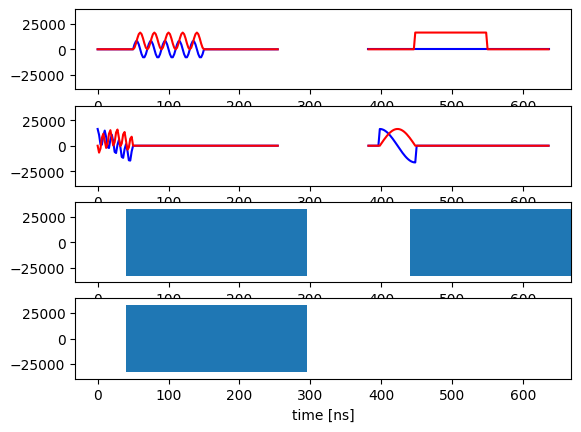

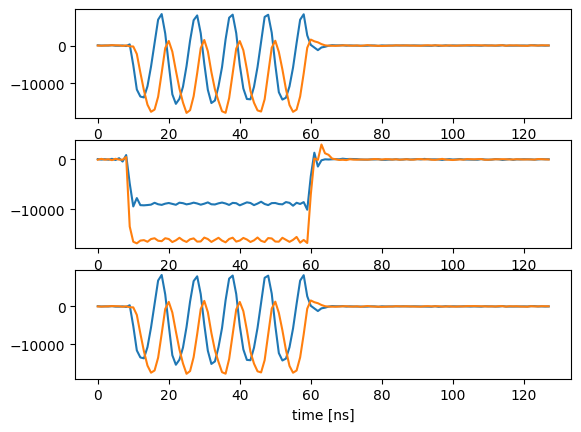

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Final
import numpy as np
# import qutip

import qubecalib as qc
import qubecalib.backendqube as be
import qubecalib.neopulse as pulse
from qubecalib.neopulse import new_sequence, new_section, AllocTable
from qubecalib.neopulse import mS, uS, nS, MHz, BLOCK, BLOCKs, WORD, WORDs
from qubecalib.neopulse import Control, Readout, Arbit, Range, Chunk, SumSect

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x400
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port6.mix.vatt = 0x400
qube.gpio.write_value(0xFFFF) # Loopback

# 論理チャネルの生成
# Q1の制御，Q1の分散読み出し，Q1Q2の交差共鳴など目的に応じた変数名をつけておくと扱いやすいです．
CQ1: Final[Control] = Control(9990*MHz)
RQ1: Final[Readout] = Readout(10000*MHz)
CQ2: Final[Control] = Control(10100*MHz)
RQ2: Final[Readout] = Readout(10050*MHz)

# 物理的な接続先がわかるように物理チャネルに名前をつける
# Qube の各ポートがどこに繋がっているかを表現した変数名をつけると扱いやすいです．
MUX1TX: Final[qc.qube.Port] = qube.port0
MUX1RX: Final[qc.qube.Port] = qube.port1
TXQ1: Final[qc.qube.Port] = qube.port5
TXQ2: Final[qc.qube.Port] = qube.port6

# 物理チャネルへの論理チャネルの割り当て表
# ここでいう物理チャネルはチャネライザも含む
alloc_table = AllocTable({
    MUX1TX.awg0: [RQ1,RQ2],
    MUX1RX.capt.unit0: [RQ1,],
    MUX1RX.capt.unit1: [RQ2,],
    TXQ1.awg0: [CQ1,CQ2],
})

# よく使うシーケンスはこのように関数化あるいはクラス化しておくのが便利です
# 面倒ですがクラス化しておくと，後述する Sequence そのものを作りなおさなくとも
# 実験のパラメータを容易に変更できるので，お勧めです
# 以下は典型的な Rabi 振動測定のための同じシーケンスを関数化，クラス化した例です．

# 関数化の例
def rabi_sequence(qch, rch, offset=0*nS):
    ctrl = Arbit(qch,begin=0*nS+offset,width=50*nS,init=1)
    read = Arbit(rch,begin=50*nS+offset,width=100*nS,init=1j)
    capt = Range(rch,begin=54*nS+offset,width=92*nS)
    return ctrl, read, capt

# クラス化の例
class RabiSequence(object):

    def __init__(self,qch,rch):
        
        self.ctrl = Arbit(qch,begin=0*nS,width=50*nS,init=1)
        self.read = Arbit(rch,begin=50*nS,width=100*nS,init=1j)
        self.capt = Range(rch,begin=54*nS,width=92*nS)

    def offset(self,time=0*nS): # シーケンス全体を時間方向に time 分ずらします
        
        s = self
        for o in [s.ctrl,s.read,s.capt]:
            o.begin += time
            
        return s # メソッドの戻り値に self を返しておくとチェーン上に重ねて変更ができるので便利です

# シーケンスを定義する部分です．with 文の中で novelpulse.Slot オブジェクトを生成すると
# Sequence オブジェクトに格納されます．
# 繰り返し測定などで実験パラメータを変更したいオブジェクトには変数に格納しておくと便利です．
# 後からアクセスしないのであれば，変数に格納しなくとも問題ありません．
with new_sequence() as sequence:
    
    sq1 = RabiSequence(CQ1,RQ1)
    sq2 = RabiSequence(CQ1,RQ1).offset(400*nS)
    rabi_sequence(CQ2,RQ2)

# e7awgsw に特化した情報を追加するのに使用します．
with new_section() as section:

    Chunk(0*nS,256*nS).alloc(
        TXQ1.awg0,
        # TXQ2.awg0,
        MUX1TX.awg0,
    )
    Chunk(384*nS,640*nS).alloc(
        TXQ1.awg0,
        # TXQ2.awg0,
        MUX1TX.awg0,
    )
    SumSect(40*nS,width=2*BLOCK).alloc(
        MUX1RX.capt.unit0,
        MUX1RX.capt.unit1
    )
    SumSect(440*nS,width=2*BLOCK).alloc(
        MUX1RX.capt.unit0,
        # MUX1RX.capt.unit1
    )

# 繰り返し測定する際のインターバルを含めて，シーケンス全体の長さを指定する
# チャネル間同期の関係で 10,240 ns の倍数でなければなりません
sequence_width = 10*mS
# sequence_width = 20*uS
constrain = 10_240*nS
period = sequence_width // constrain * constrain

setup = pulse.convert(sequence, section, alloc_table, period)

capture_delay = d = 5 * 16
setup.get(MUX1RX.capt.unit0).capture_delay += d # words
setup.get(MUX1RX.capt.unit1).capture_delay += d # words

fig = plt.figure()
pulse.plot_setup(fig,setup,capture_delay=d)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

r = be.send_recv(*setup)

fig = plt.figure()
pulse.plot_send_recv(fig,r)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

# print('pulse')
# fig = plt.figure()
# for i,k in enumerate(a):
#     if i == 0:
#         ax = ax1 = fig.add_subplot(len(a)*100+10+i+1)
#     else:
#         ax = fig.add_subplot(len(a)*100+10+i+1, sharex=ax1)
#     for v in r[k]:
#         if isinstance(v,Range):
#             ax.add_patch(patches.Rectangle(xy=(v.begin,-1),width=v.width,height=2))
#         else:
#             t = v.sampling_points
#             d = v.miq
#             ax.plot(t,np.real(d),'b')
#             ax.plot(t,np.imag(d),'r')
#             ax.set_ylim(-1.2,1.2)
# plt.show()

# fig = plt.figure()
# for i,k in enumerate(awgs):
#     if i == 0:
#         ax = ax1 = fig.add_subplot(len(awgs)*100+10+i+1)
#     else:
#         ax = fig.add_subplot(len(awgs)*100+10+i+1, sharex=ax1)
#     for s in section[k]:
#         t = s.sampling_points
#         ax.plot(t,np.real(s.iq),'b')
#         ax.plot(t,np.imag(s.iq),'r')
#         ax.set_ylim(-1.2,1.2)
# plt.show()

# print(wseqs)

# def plot_wseqs(fig,*wseqs):
#     for i,tpl in enumerate(wseqs):
#         k,w = tpl
#         if i == 0:
#             ax = ax1 = fig.add_subplot(len(wseqs)*100+10+i+1)
#         else:
#             ax = fig.add_subplot(len(wseqs)*100+10+i+1, sharex=ax1)
#         blank = [c.num_blank_words * int(WORDs) for c in w.chunk_list]
#         begin = w.num_wait_words * int(WORDs)
#         for cc,bb in zip(w.chunk_list,blank):
#             iq = np.array(cc.wave_data.samples)
#             t = np.arange(len(iq)) * 2 + begin
#             begin = t[-1] + bb
#             ax.plot(t,iq[:,0],'b')
#             ax.plot(t,iq[:,1],'r')
#             ax.set_ylim(-32767*1.2,32767*1.2)

# fig = plt.figure()
# plot_wseqs(fig,*wseqs)
# fig.axes[1].set_xlabel('time [ns]')
# plt.show()



